# Importing libraries

In [ ]:
%pip install osmnx
%pip install rasterio
%pip install rasterstats
%pip install contextily
%pip install geopandas
%pip install matplotlib

In [2]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
from shapely.geometry import box
import contextily as ctx
import rasterio
import geopy.distance
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import math
import yaml
import pickle
import time
from scipy.sparse.csgraph import floyd_warshall

# Data

## Configs

In [3]:
with open("configs/params.yaml", "r") as f:
    config = yaml.safe_load(f)
    params = config

## City graph

In [4]:
def create_graph_network(city_params):
    G = ox.graph_from_place(city_params["name"], network_type = city_params["graph_type"])
    G.to_undirected()
    return G

In [5]:
G = ox.graph_from_place(params["city"]["name"], network_type="drive")

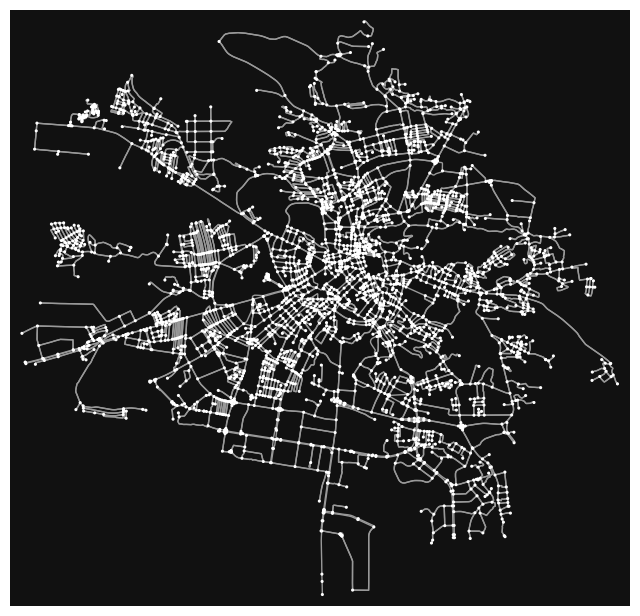

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph(G, node_size=5)

## Division into sectors

In [7]:
def division_into_secors(city_params):
    city_boundary = ox.geocode_to_gdf(city_params["name"])

    xmin, ymin, xmax, ymax = city_boundary.total_bounds
    grid_size = 0.0125

    grid_cells = []
    for x in np.arange(xmin, xmax, grid_size):
        for y in np.arange(ymin, ymax, grid_size):
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=city_boundary.crs)
    map_with_grid = gpd.clip(grid, city_boundary)

    return map_with_grid, city_boundary

Assigning graph nodes to a grid cell (region)

In [8]:
def nodes_to_region(G, map_with_grid):
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)
    nodes_gdf = nodes_gdf.set_geometry(nodes_gdf.geometry)

    nodes_in_grid = gpd.sjoin(nodes_gdf, map_with_grid, how="left", predicate="within")
    nodes_in_grid = nodes_in_grid.reset_index()

    # Handling nodes that are not assigned to any grid cell. Creating node to region dictionary and region to nodes dictiionary
    assigned_nodes = nodes_in_grid.dropna(subset=["index_right"]) 
    missing_nodes = nodes_in_grid[nodes_in_grid["index_right"].isna()]

    tree = cKDTree(assigned_nodes[["x", "y"]].values)
    _, nearest_idx = tree.query(missing_nodes[["x", "y"]].values)

    nodes_in_grid.loc[nodes_in_grid["index_right"].isna(), "index_right"] = assigned_nodes.iloc[nearest_idx]["index_right"].values
    nodes_in_grid["index_right"] = nodes_in_grid["index_right"].astype(int)

    # region -> list of nodes
    region_to_nodes = nodes_in_grid.groupby(nodes_in_grid.index_right)["osmid"].apply(list).to_dict()
    # node -> region DI
    node_to_region = nodes_in_grid.set_index("osmid")["index_right"].to_dict()
    regions = [region for region in region_to_nodes]

    return regions, region_to_nodes, node_to_region


## Calculating population for each region

Population for each region

In [9]:
def population_estimation(regions, map_with_grid, city_params):
    
    # Population count for each sector
    raster_file_population = city_params["raster_file_population"]
    with rasterio.open(raster_file_population) as data:
        affine = data.transform
        array = data.read(1)
    stats = zonal_stats(map_with_grid, raster_file_population, stats=["sum"], affine=affine)
    map_with_grid["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]
    map_with_grid = map_with_grid.reset_index()

    # Creating dictionary: region -> population
    region_to_populatoin = dict()
    for grid_cell in range(len(map_with_grid)):
        region_id = map_with_grid.iloc[grid_cell]["index"]
        if region_id in regions:
            population = map_with_grid.iloc[grid_cell]["population"]
            region_to_populatoin[region_id] = population
    
    return region_to_populatoin

## Distance matrix

In [10]:
def calculate_distamnce_matrix(G):
    nodes = list(G.nodes)
    n = len(nodes)
    node_index = {node: idx for idx, node in enumerate(nodes)}

    # Creating adjacency matrix
    D = np.full((n, n), np.inf)

    for u, v, data in G.edges(data=True):
        length = data.get("length", np.inf)
        i, j = node_index[u], node_index[v]
        D[i, j] = length
        D[j, i] = length
    np.fill_diagonal(D, 0)

    # Using optimized Floyd-Warshall
    D = floyd_warshall(D, directed=False)
    np.save("distance_matrix_lviv.npy", D)
    return D


In [11]:
def distance_matrix(G, city_params):
    if city_params["distance_matrix"]:
        return np.load(city_params["distance_matrix"])
    return calculate_distamnce_matrix(G)

## Substations

In [12]:
def find_substations(city_name):
    substations = ox.features_from_place(city_name, tags={"power": "substation"})
    substations = substations[['geometry']].reset_index()
    return substations

In [13]:
def calculate_distance_to_substation(G, substations):
    dist_to_substation = dict()
    for node in G.nodes():
        node_lat, node_lon = G.nodes[node]['y'], G.nodes[node]['x']
        distances = []
        for _, row in substations.iterrows():
            if row.geometry.geom_type == "Point":
                substation_lat, substation_lon = row.geometry.y, row.geometry.x
                distance_m = geopy.distance.geodesic((node_lat, node_lon), (substation_lat, substation_lon)).m
                distances.append(distance_m)
        dist_to_substation[node] = min(distances)
    return dist_to_substation

# Demand simulation

## Data Preperation

In [14]:
def create_cs_dataframe(solution, station_params):
    # Merge installed station and solution station data
    station_node_list, capacity_list, station_ports_list  = [], [], []

    for (station_node, station_type), station_ports in solution.items():
        capacity = station_params["types"][station_type]["capacity"]

        station_node_list.append(station_node)
        capacity_list.append(capacity)
        station_ports_list.append(station_ports)

    # Create station dataframes
    charging_station_df = pd.DataFrame({
        "cs_id": range(len(station_node_list)),
        "node": station_node_list,
        "capacity": capacity_list,
        "num_of_ports": station_ports_list,
    })
    return charging_station_df

In [15]:
def create_cs_occupation_dataframe(charging_station_df, simulation_hours):
    cs_occupation_df = pd.DataFrame(columns=["cs_id", "capacity", "port", "hour", "occupation_time"])
    
    for _, row in charging_station_df.iterrows():
        cs_id = row["cs_id"]
        capacity = row["capacity"]
        number_of_ports = int(row["num_of_ports"])

        # Creating rows for each port and hour
        for port in range(1, number_of_ports + 1):
            for hour in range(simulation_hours):
                cs_occupation_df.loc[len(cs_occupation_df)] = {"cs_id": cs_id, "capacity": capacity, "port": port, "hour": hour, "occupation_time": 0.0}

    cs_occupation_df["cs_id"] = cs_occupation_df["cs_id"].astype(int)
    return cs_occupation_df

## EV generation

In [16]:
def generate_route(ev, nodes):
    locations = []
    departure_times = []

    # Fron home
    home_location = ev["home_location"]
    morning_commute_hour = ev["commute_hours"]["morning"]
    
    # Route destinations
    number_of_destinations = random.choices([1, 2, 3], weights = [0.6, 0.3, 0.1], k=1)[0] # Generating number of destinations that are not home
    
    locations.append(home_location) # Home location (start point)
    random_locations = random.choices(nodes, k = number_of_destinations) # Work and other locations
    for location in random_locations:
        while location == home_location:
                location = random.choice(nodes)
        locations.append(location)
    locations.append(home_location) # Home location (end point)

    # Route times
    trip_time = {
        "random morning trip": range(0, ev["commute_hours"]["morning"]),
        "random noon trip": range(ev["commute_hours"]["morning"], ev["commute_hours"]["evening"]),
        "random evening trip": range(ev["commute_hours"]["evening"], 24)
    }
    
    departure_times.append(morning_commute_hour) # Departure to work

    if number_of_destinations > 1:
        for i in range(number_of_destinations-1):
            ranom_trip_type = random.choice(["random morning trip", "random noon trip", "random evening trip"])
            random_trip_time = random.choice(trip_time[ranom_trip_type])
            departure_times.append(random_trip_time)

    departure_times.append(ev["commute_hours"]["evening"]) # Departure from work
    departure_times.sort()

    parking_periods = []
    for i in range(number_of_destinations + 2): # +2 since the route starts and ends at home
        if i == 0:
            parking_periods.append([0, departure_times[i]-1])
        elif i == number_of_destinations + 1:
            parking_periods.append([departure_times[i-1], 23])
        else:
            parking_periods.append([departure_times[i-1], departure_times[i]-1])
    return locations, parking_periods

In [17]:
def generate_EVs(regions, region_to_population, region_to_nodes, nodes, params):
    EVs = []
    ev_id = 0

    for region in regions:
        ev_num = int(region_to_population[region] * params["ev"]["ev_per_capita"])

        potential_home_locations = region_to_nodes[region]
        if len(potential_home_locations) == 0:
            break
        ev_home_locations = random.choices(potential_home_locations, k = ev_num)
        for i in range(ev_num):
            battery_capacity = params["ev"]["battery_capacity"]
            initial_soc_range = params["simulation"]["initial_soc_range"]
            charging_threshold = params["simulation"]["charging_threshold"]
            target_charge = params["simulation"]["target_charge"]
            morning_commute_hours = params["simulation"]["commute_hours"]["morning"]
            evening_commute_hours = params["simulation"]["commute_hours"]["evening"]

            ev = {
                    "ev_id": ev_id,
                    "home_location": ev_home_locations[i],
                    "previous_location": ev_home_locations[i],
                    "battery_capacity": random.uniform(battery_capacity[0], battery_capacity[1]),
                    "current_charge": None,  # Will be assigned below
                    "charging_threshold": random.uniform(charging_threshold[0], charging_threshold[1]),  # When to start charging
                    "target_charge": random.uniform(target_charge[0], target_charge[1]),  # Target charge level
                    "commute_hours": {
                        "morning": random.randint(morning_commute_hours[0], morning_commute_hours[1]),  # Morning commute hour (6-9 AM)
                        "evening": random.randint(evening_commute_hours[0], evening_commute_hours[1])  # Evening commute hour (4-7 PM)
                    },
                    "destinations": None,  # Will be assigned below
                    "parking_periods": None  # Will be assigned below
            }
            
            # Assigning current state of charge
            ev["current_charge"] = ev["battery_capacity"] * random.uniform(initial_soc_range[0], initial_soc_range[1])

            # Assigning route (destinations + departure_times)
            destinations, parking_periods = generate_route(ev, nodes)
            ev["destinations"] = destinations
            ev["parking_periods"] = parking_periods
            EVs.append(ev)
            ev_id +=1
    return EVs

## EV charging

In [18]:
def needs_charge(ev):
    return (ev["current_charge"] < ev["battery_capacity"]*ev["charging_threshold"])

In [19]:
def nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id):
    nearest_cs = charging_station_df.copy()

    nearest_cs["distance"] = nearest_cs["node"].apply(lambda x: dist_matrix[nodes_id[current_location], nodes_id[x]])
    nearest_cs = nearest_cs.sort_values(by = ["distance", "capacity"], ascending=[True, False])
    return nearest_cs[nearest_cs["distance"] < float("inf")]

In [20]:
def charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params):
    # Calculating needed energy
    energy_needed = ev["battery_capacity"] * ev["target_charge"] - ev["current_charge"]
    total_energy_needed = energy_needed/(1-params["charging_stations"]["energy_loss"])
    
    # Calculating departure time (from charging station to next location)
    for j in range(len(ev["parking_periods"])):
        parking_period_start, parking_period_end = ev["parking_periods"][j]
        if hour in range(parking_period_start, parking_period_end + 1):
            departure_time = parking_period_end + 1

    # Searching for a nearest charging station
    while True:
        if len(nearest_cs_df) == 0:
            print("No charhing station is reachable")
            return charging_session_df, cs_occupation_df, ev

        for i in range(len(nearest_cs_df)):
            charging_station_data = nearest_cs_df.iloc[i]
            cs_node = charging_station_data["node"]
            cs_id = charging_station_data["cs_id"]
            cs_capacity = charging_station_data["capacity"]
            num_of_ports = int(charging_station_data["num_of_ports"])
            distance = charging_station_data["distance"]
            # Searching for a free port
            for port in range(1, num_of_ports + 1):
                port_occupation_data = cs_occupation_df[(cs_occupation_df["cs_id"]==cs_id) & (cs_occupation_df["hour"]==hour)&(cs_occupation_df["port"]==port)]
                port_occupation_time = port_occupation_data["occupation_time"].iloc[0]
                if port_occupation_time < 60:
                    break
            if port_occupation_time < 60: # To exit the first For loop
                break

        # If at the current hour each port is occupied for 60 minutes
        # then it is necessary to search for a free port in the next hour, if the day hasn't ended
        if port_occupation_time != 60:
            break
        else:
            if hour + 1 < 24 and hour + 1 < departure_time:
                hour +=1
            else:
                return charging_session_df, cs_occupation_df, ev
        
    # Calculating charging time
    charging_time_minutes = (total_energy_needed/cs_capacity)*60
    # EV charges until it is time for the next trip or until it is charged
    charging_time_minutes = min(charging_time_minutes, max(0, (departure_time - hour)*60 - port_occupation_time))

    # Update charging station occupation dataframe
    if port_occupation_time + charging_time_minutes <=60:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = port_occupation_time + charging_time_minutes
        charging_end_hour = hour
    else:
        cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
        charging_time_left = charging_time_minutes + port_occupation_time - 60
        next_hour = hour + 1
        while charging_time_left > 60 and next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = 60
            charging_time_left -= 60
            next_hour +=1
        if next_hour < 24:
            cs_occupation_df.loc[(cs_occupation_df["cs_id"] == cs_id) & (cs_occupation_df["hour"] == next_hour) & (cs_occupation_df["port"] == port),\
                              "occupation_time"] = charging_time_left
        charging_end_hour = min(23, next_hour)

    # Add new session
    new_session = {
        "cs_id": cs_id,
        "node": cs_node,
        "capacity": cs_capacity,
        "port": port,
        "charging_start_hour": hour,
        "charging_end_hour": charging_end_hour,
        "session_duration": charging_time_minutes,
        "ev_id": ev["ev_id"],
        "distance_from_ev": distance,
        "energy_used": cs_capacity*(charging_time_minutes/60)
    }
        
    charging_session_df.loc[len(charging_session_df)] = new_session
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    # Update EV data
    ev["current_charge"] = ev["current_charge"] + cs_capacity*(charging_time_minutes/60)
    ev["previous_location"] = cs_node

    return charging_session_df, cs_occupation_df, ev

## Demand Simulation

In [21]:
def simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes, dist_matrix, nodes_id):
    """
    A simple simulation model for EV charging demand over a 24-hour period.
    
    Parameters:
    -----------
    simulation_hours : int
        Number of hours to simulate (typically 24)
    avg_daily_miles : float
        Average miles driven per day per EV
    kwh_per_mile : float
        Average energy consumption per mile (kWh)
    avg_battery_capacity : float
        Average EV battery capacity in kWh
    home_charging_probability : float
        Probability that an EV will charge at home overnight
    
    Returns:
    --------
    DataFrame with hourly charging demand per node
    """
    random.seed(12)
    regions = list(region_to_population.keys())
    nodes = list(node_to_region.keys())
    simulation_hours = params["simulation"]["simulation_hours"]

    charging_station_df = create_cs_dataframe(solution, params["charging_stations"])

    charging_session_df = pd.DataFrame(columns = ["cs_id", "node", "capacity", "port", "charging_start_hour", \
                                          "charging_end_hour", "session_duration", "ev_id", "distance_from_ev", "energy_used"])
    charging_session_df["cs_id"] = charging_session_df["cs_id"].astype(int)
    charging_session_df["node"] = charging_session_df["node"].astype(int)

    cs_occupation_df = create_cs_occupation_dataframe(charging_station_df, simulation_hours)

    # For each region initialize ev
    EVs = generate_EVs(regions, region_to_population, region_to_nodes, nodes, params)

    avg_consumption_per_km = params["ev"]["avg_consumption_per_km"] #Wh/km

    # Simulate each hour
    for hour in range(simulation_hours):

        # For each EV
        for i in range(len(EVs)):
            ev = EVs[i]
            
            previous_location = ev["previous_location"]
            # Update location and state of charge
            for j in range(len(ev["parking_periods"])):
                parking_period_start, parking_period_end = ev["parking_periods"][j]
                if hour in range(parking_period_start, parking_period_end + 1):
                    current_location = ev["destinations"][j]
                    break
            if previous_location != current_location:
                distance = dist_matrix[nodes_id[previous_location], nodes_id[current_location]]
                energy_used = distance * (avg_consumption_per_km/1000)
                ev["current_charge"] -= energy_used

            # Charge if needed
            if needs_charge(ev):
                nearest_cs_df = nearest_cs_search(charging_station_df, current_location, dist_matrix, nodes_id)
                charging_session_df, cs_occupation_df, ev = charge_ev(nearest_cs_df, charging_session_df, cs_occupation_df, hour, ev, params)

            ev["previous_location"] = current_location
    
    return cs_occupation_df, charging_session_df

# Fitness Evaluation

### 1) CS cost evaluation

Total CS cost:\
$cs\_cost = \sum^N_{i=1}\sum_{n \in cs\_type} cost_{n,i}*X_{n,i}$

In [22]:
def cs_cost_penalty(solution, station_params):
    total_cost = 0
    for charging_station in solution:
        cs_type = charging_station[1]
        cost = station_params["types"][cs_type]["cost"]
        number_of_ports = solution[charging_station]
        total_cost += cost*number_of_ports
    return total_cost

### 2) Average charging time per 1kWh evaluation

In [23]:
def avg_time_per_kWh(charging_session_data):
    return sum(charging_session_data["session_duration"])/(sum(charging_session_data["energy_used"])/1000)

### 3) Average distance to charging station evaluation

In [24]:
def average_distance_to_cs(charging_session_data):
    return charging_session_data["distance_from_ev"].mean()

### 4) Grid loss

In [25]:
def total_grid_loss(solution, distance_to_substations):
    total_distance = 0
    for station in solution:
        cs_node = station[0]
        total_distance += distance_to_substations[cs_node]
    return total_distance

### Evaluation function

$evaluation = \alpha*cs\_cost + \beta*avg\_time\_per\_kWh + \gamma*avg\_distance + \delta*grid\_loss$

In [26]:
def evaluate_fitness(solution, params, dist_matrix, region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations):
    alpha = params["evaluation_weights"]["alpha"]
    beta = params["evaluation_weights"]["beta"]
    gamma = params["evaluation_weights"]["gamma"]
    delta = params["evaluation_weights"]["delta"]

    cs_occupation_df, charging_session_data = simulate_charging_demand(solution, params, region_to_population, node_to_region, region_to_nodes,
                                dist_matrix, nodes_id)

    cs_cost = cs_cost_penalty(solution, params["charging_stations"])
    avg_charging_time_kWh = avg_time_per_kWh(charging_session_data)
    avg_distance= average_distance_to_cs(charging_session_data)
    grid_loss = total_grid_loss(solution, distance_to_substations)

    fitness = alpha*cs_cost + beta*avg_charging_time_kWh + gamma*avg_distance + delta*grid_loss
    return fitness, alpha*cs_cost, beta*avg_charging_time_kWh, gamma*avg_distance, delta*grid_loss

# Simulated Annealing Algorithm

**The form in which the solution is presented:**\
$x\ =\ \{$ \
$\ \ \ \ (i, 'station\_type'): n$ \
$\}$

Where\
$i$ - node_id,\
$n$ - number of stations (of this type) in the node $i$

## Initialization

- 1 solution
- 5-100 random stations for each solution
- random cs type

In [27]:
def initialize_solution(nodes, station_types):
    solution = {}

    for node in random.sample(nodes, k=random.randint(10, 100)):
        cs_type = random.choice(station_types)
        cs_number = random.choices([1,2,3,4], [0.3, 0.4, 0.2, 0.1])[0]
        solution[(node, cs_type)] = cs_number
    return solution

## Generate new solution

In [28]:
def add_random_station(solution, nodes, cs_types, max_ports_per_node):
    new_solution = solution.copy()

    # Calculating total number of cs ports in each node
    total_node_ports = {cs_node: 0 for cs_node, cs_type in new_solution}
    for station in new_solution:
        total_node_ports[station[0]] = total_node_ports[station[0]] + new_solution[station]
        
    num_of_stations = random.choices([1, 2, 3, 4, 5, 6], [0.05, 0.1, 0.15, 0.2, 0.25, 0.25])[0]
    for i in range(num_of_stations):

        # Generate random node, type 
        random_node = random.choice(nodes)
        cs_type = random.choice(cs_types)
        while random_node in total_node_ports.keys() and total_node_ports[random_node] == max_ports_per_node:
            random_node = random.choice(nodes)

        # Generate random number of ports taking into account number of existing stations in the node
        if random_node in total_node_ports.keys():
            num_of_ports = random.choice(range(0, max_ports_per_node - total_node_ports[random_node])) + 1
        else:
            num_of_ports = random.choice(range(0, max_ports_per_node)) + 1

        # Generate random number of ports taking into account number of existing stations in the node
        if (random_node, cs_type) in new_solution:
            new_solution[(random_node, cs_type)] = new_solution[(random_node, cs_type)] + num_of_ports
        else:
            new_solution[(random_node, cs_type)] = num_of_ports

        # Update num_cs_ports
        if random_node in total_node_ports.keys():
            total_node_ports[random_node] = total_node_ports[random_node] + num_of_ports
        else: 
            total_node_ports[random_node] = num_of_ports
    return new_solution

In [29]:
def remove_random_station(solution):
    new_solution = solution.copy()

    num_of_stations = random.choices([1, 2, 3, 4, 5, 6], [0.05, 0.1, 0.15, 0.2, 0.25, 0.25], k = 1)[0]
    num_of_stations = min(num_of_stations, len(list(new_solution.keys())))

    for i in range(num_of_stations):
        random_station = random.choice(list(new_solution.keys()))
        num_of_ports_remove = random.choice(range(1, new_solution[random_station] + 1)) 

        if num_of_ports_remove < new_solution[random_station]:
            new_solution[random_station] = new_solution[random_station] - num_of_ports_remove
        else:
            new_solution.pop(random_station)
    return new_solution

In [30]:
def change_station_type(solution, cs_types, max_ports_per_node):
    new_solution = solution.copy()
    num_of_stations = random.choices([1, 2, 3, 4], [0.4, 0.3, 0.2, 0.1])[0]

    for i in range(num_of_stations):
        cs_node, cs_type = random.choice([station for station in new_solution])
        new_cs_types_list = cs_types.copy()
        new_cs_types_list.remove(cs_type)

        new_cs_type = random.choice(new_cs_types_list)
        if (cs_node, new_cs_type) in new_solution:
            new_solution[(cs_node, new_cs_type)] = min(max_ports_per_node, \
                                                       new_solution[(cs_node, cs_type)] + new_solution[(cs_node, new_cs_type)])
        else:
            new_solution[(cs_node, new_cs_type)] = new_solution[(cs_node, cs_type)]

        new_solution.pop((cs_node, cs_type))
    
    return new_solution

In [31]:
def generate_new_solution(solution, nodes, station_params):
    rng = random.Random()
    cs_types = station_params["types_list"]
    max_ports_per_node = station_params["max_ports_per_node"]

    action = rng.choice(["add", "remove", "change_type"])
    print(action)
    if action == "add":
        new_solution = add_random_station(solution, nodes, cs_types, max_ports_per_node)
    elif action == "remove":
        new_solution = remove_random_station(solution)
    else:
        new_solution = change_station_type(solution, cs_types, max_ports_per_node)

    return new_solution

## Simulated Annealing Algorithm

In [ ]:
def SA_algorithm(G, dist_matrix, params, region_to_population, node_to_region, region_to_nodes, distance_to_substations):
    
    sa_params = params["simulated_annealing"]
    station_params = params["charging_stations"]

    nodes = list(G.nodes)
    nodes_id = {nodes[i]: i for i in range(len(nodes))}

    cs_types = station_params["types_list"]

    current_solution = initialize_solution(nodes, cs_types)
    best_solution = current_solution

    current_fitness, fitness_cost, fitness_charging_time, fitness_avg_distance, fitness_grid_loss = evaluate_fitness(current_solution, params, dist_matrix,\
                                    region_to_population, node_to_region, region_to_nodes, nodes_id, distance_to_substations)
    best_fitness = current_fitness
    best_fitness_list = [[current_fitness, fitness_cost, fitness_charging_time, fitness_avg_distance, fitness_grid_loss]]

    
    T = sa_params["initial_temperature"]
    cooling_rate = sa_params["cooling_rate"]
    iterations = sa_params["iterations"]
    bad_attempts_limit = sa_params["bad_attempts_limit"]
    testing_worse_solution = False
    for iteration in range(iterations):
        print("Iteration", iteration + 1, "/", iterations)

        new_solution = generate_new_solution(current_solution, nodes, station_params)
        new_fitness, new_fitness_cost, new_fitness_charging_time, new_fitness_avg_distance, new_fitness_grid_loss = evaluate_fitness(new_solution, params, dist_matrix, region_to_population, node_to_region,
                                        region_to_nodes, nodes_id, distance_to_substations)
        delta_fitness = new_fitness - current_fitness
        # print("delta_fitness: ", round(delta_fitness, 1))
        # print("probability: ", math.exp(-delta_fitness / T))

        if delta_fitness < 0 or (random.random() < math.exp(-delta_fitness / T)):
            current_solution = new_solution
            current_fitness = new_fitness
            if delta_fitness > 0:
                testing_worse_solution = True
                bad_attemmpts = bad_attempts_limit
            else:
                testing_worse_solution = False

            if current_fitness < best_fitness:
                best_solution = current_solution
                best_fitness = current_fitness
                best_fitness_list.append([new_fitness, new_fitness_cost, new_fitness_charging_time, new_fitness_avg_distance, new_fitness_grid_loss])
            else:
                best_fitness_list.append(best_fitness_list[-1]) # when best solution hasn't changed
        else:
            best_fitness_list.append(best_fitness_list[-1]) # when best solution hasn't changed
            if testing_worse_solution:
                bad_attemmpts -=1
        if testing_worse_solution and bad_attemmpts == 0:
            current_solution = best_solution
            current_fitness = best_fitness
            testing_worse_solution = False

        T *= cooling_rate

    return best_solution, best_fitness_list

## Visualization

In [41]:
def visualize_solution(solution, G):
    cs_lists_by_type = dict()
    for charging_station in solution:
        cs_node = charging_station[0]
        cs_type = charging_station[1]
        if cs_type in list(cs_lists_by_type.keys()):
            cs_lists_by_type[cs_type].append(cs_node)
        else:
            cs_lists_by_type[cs_type] = [cs_node]

    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
    G_undirected = G.to_undirected()
    G_undirected.remove_edges_from(nx.selfloop_edges(G_undirected))
    fig, ax = plt.subplots(figsize=(12, 9), facecolor="black")


    nx.draw(G_undirected, pos, node_size=2, with_labels=False, node_color="darkgray", edge_color="darkgray", ax=ax)

    unique_cs_types = list(cs_lists_by_type.keys())
    color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))
                 for i, cs_type in enumerate(unique_cs_types)}

    # Drawing charging station nodes with different colors based on their type
    for cs_type, nodes in cs_lists_by_type.items():
        nx.draw_networkx_nodes(
            G_undirected,
            pos,
            nodelist=nodes,
            node_size=20,
            node_color=[color_map[cs_type]] * len(nodes),
            label=f"{cs_type} Stations",
            ax=ax
        )

    legend = plt.legend(scatterpoints=1, frameon=True, loc="upper right", facecolor="white", edgecolor="darkgray", bbox_to_anchor=(1.5, 1))
    for text in legend.get_texts():
        text.set_color("black")

    plt.title("Graph with Stations", color="darkgrey")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


In [34]:
def plot_total_fitness(best_fitness_list):
    plt.figure(figsize=(15, 10))
    fitness = [iteration[0] for  iteration in best_fitness_list]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Total Fitness of the best solution for each iteration for SAA model')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [35]:
def plot_models_fitness(fitness_lists, parameters):
    plt.figure(figsize=(15, 10))

    fitness = [iteration[0] for  iteration in fitness_lists]
    fitness_cost = [iteration[1] for  iteration in fitness_lists]
    fitness_charging_time = [iteration[2] for  iteration in fitness_lists]
    fitness_avg_distance = [iteration[3] for  iteration in fitness_lists]
    fitness_grid_loss = [iteration[4] for  iteration in fitness_lists]
    n = len(fitness)
    plt.plot(range(n), fitness, label = "Total evaluation")
    plt.plot(range(n), fitness_cost, label = f"Cost evaluation, weight = {parameters['alpha']}")
    plt.plot(range(n), fitness_charging_time, label = f"Average charging time per kWh evaluation, weight = {parameters['beta']}")
    plt.plot(range(n), fitness_avg_distance, label = f"Average distance evaluation, weight = {parameters['gamma']}")
    plt.plot(range(n), fitness_grid_loss, label = f"Grid loss evaluation, weight = {parameters['delta']}")

    plt.xlabel('Iteration')
    plt.ylabel('Best fitness')
    plt.title(f'Fitness values of the best solution for each iteration for SA')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Simulated Annealing model

In [49]:
def run_sa(base_config_file, exp_name, exp_config_file = None):
    with open(base_config_file, "r") as f:
        params = yaml.safe_load(f)
    
    if exp_config_file:
        with open(exp_config_file, "r") as f:
            exp_params = yaml.safe_load(f)
        params.update(exp_params)

    city_params = params["city"]

    # Graph
    G = create_graph_network(city_params)

    # Calculating distance matrix
    dist_matrix = distance_matrix(G, city_params)

    # Calculating distance from nodes to substations
    substations = find_substations(city_params["name"])
    distance_to_substations = calculate_distance_to_substation(G, substations)

    # Division into sectors + demand estimation
    map_with_grid, city_boundary = division_into_secors(city_params)
    regions, region_to_nodes, node_to_region = nodes_to_region(G, map_with_grid)
    region_to_population = population_estimation(regions, map_with_grid, city_params)

    # SA
    start_time = time.time()
    best_solution, best_fitness_list = SA_algorithm(G, dist_matrix, params, region_to_population, 
                                                    node_to_region, region_to_nodes, distance_to_substations)
    runtime = time.time() - start_time
    result = {
        "algorithm": "SA",
        "fitness_history": best_fitness_list,
        "runtime": runtime,
        "solution": best_solution
    }
    with open(exp_name, 'wb') as f:
        pickle.dump(result, f)

    # Visualization
    # plot_models_fitness(best_fitness_list, params["evaluation_weights"])
    # plot_total_fitness(best_fitness_list)
    # visualize_solution(best_solution, G)

# Experiments

## Experiment 0

- base parameters

In [ ]:
run_sa("configs/params.yaml", "exp_sa_0.pkl", exp_config_file = None)

In [ ]:
with open("exp_sa_0.pkl", "rb") as f:
    exp_result = pickle.load(f)
exp_result["runtime"]

1704.601571559906

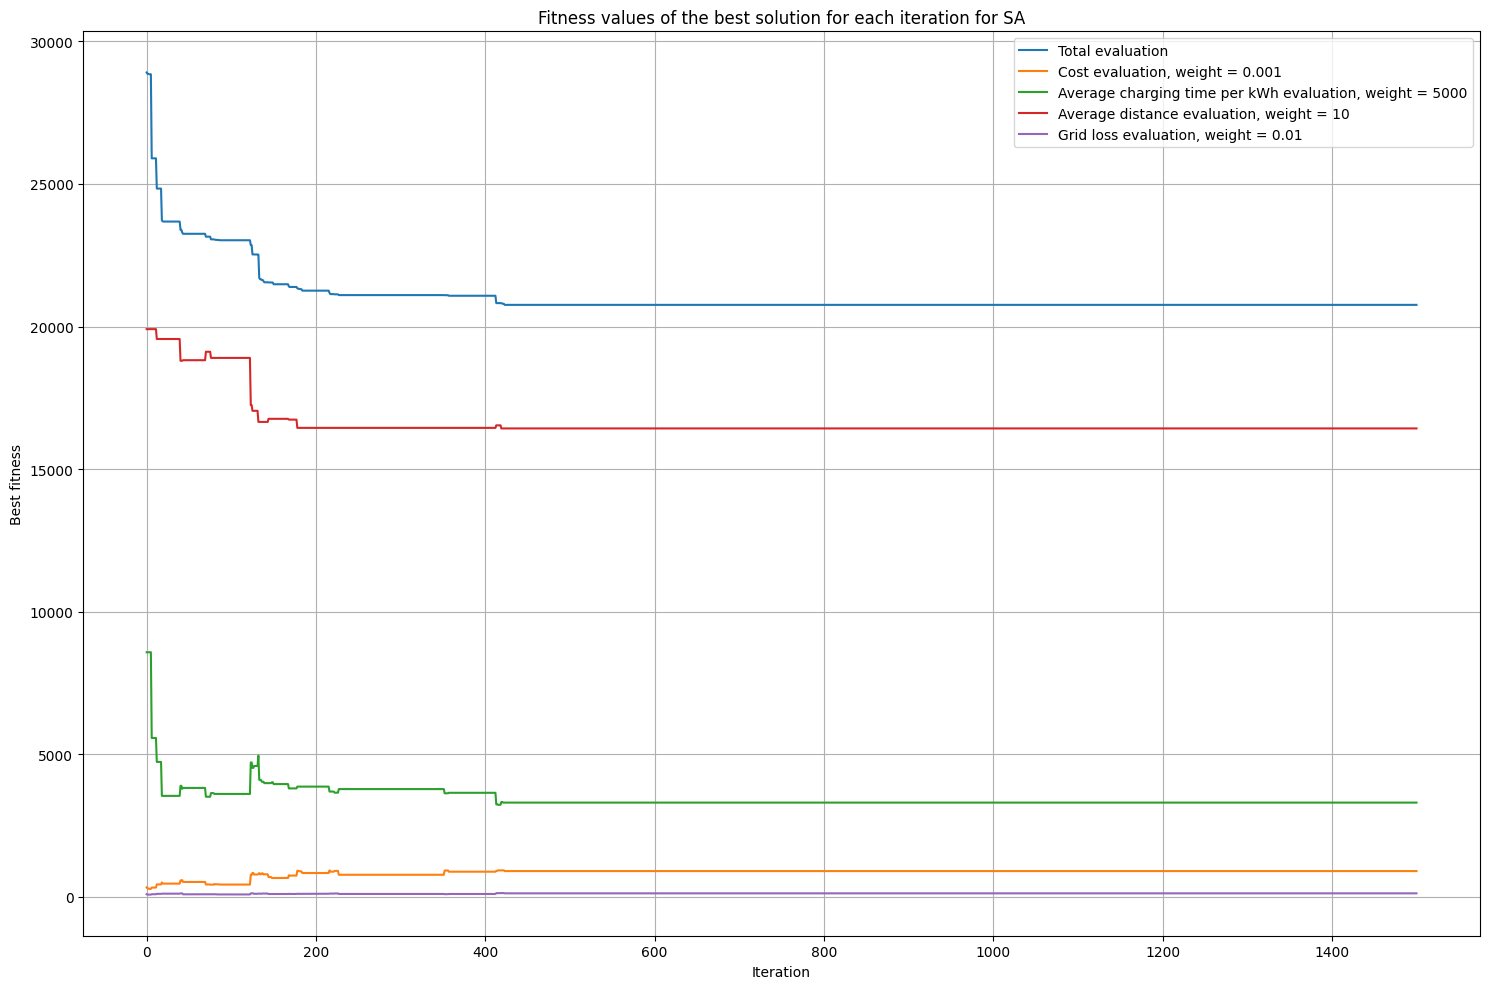

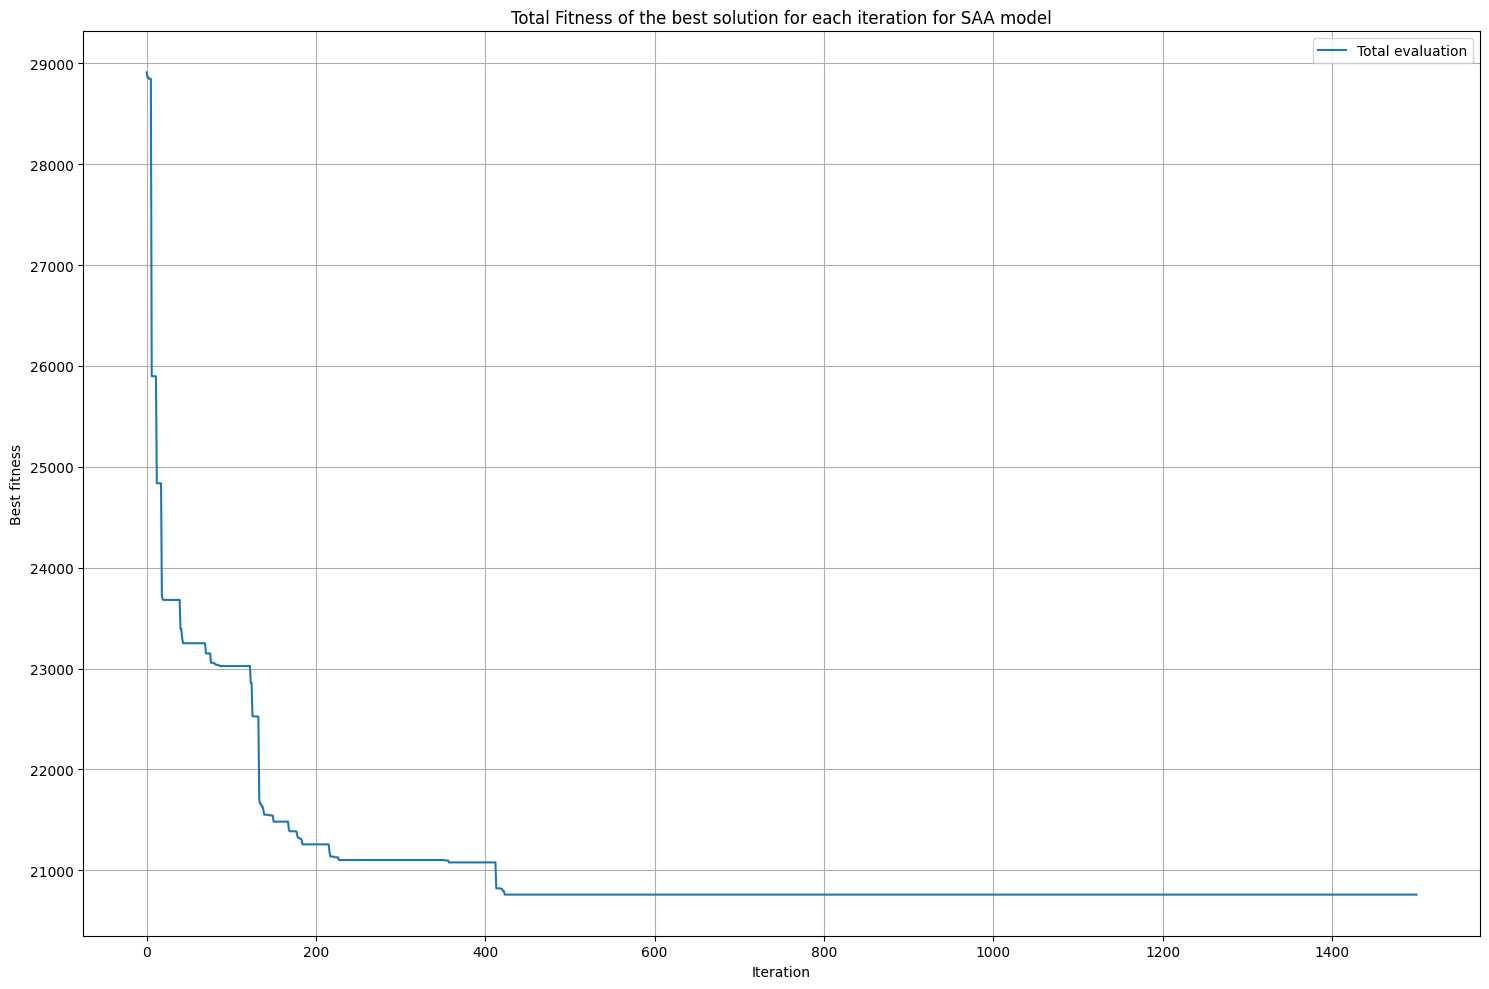

C:\Users\tetia\AppData\Local\Temp\ipykernel_27360\777376565.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


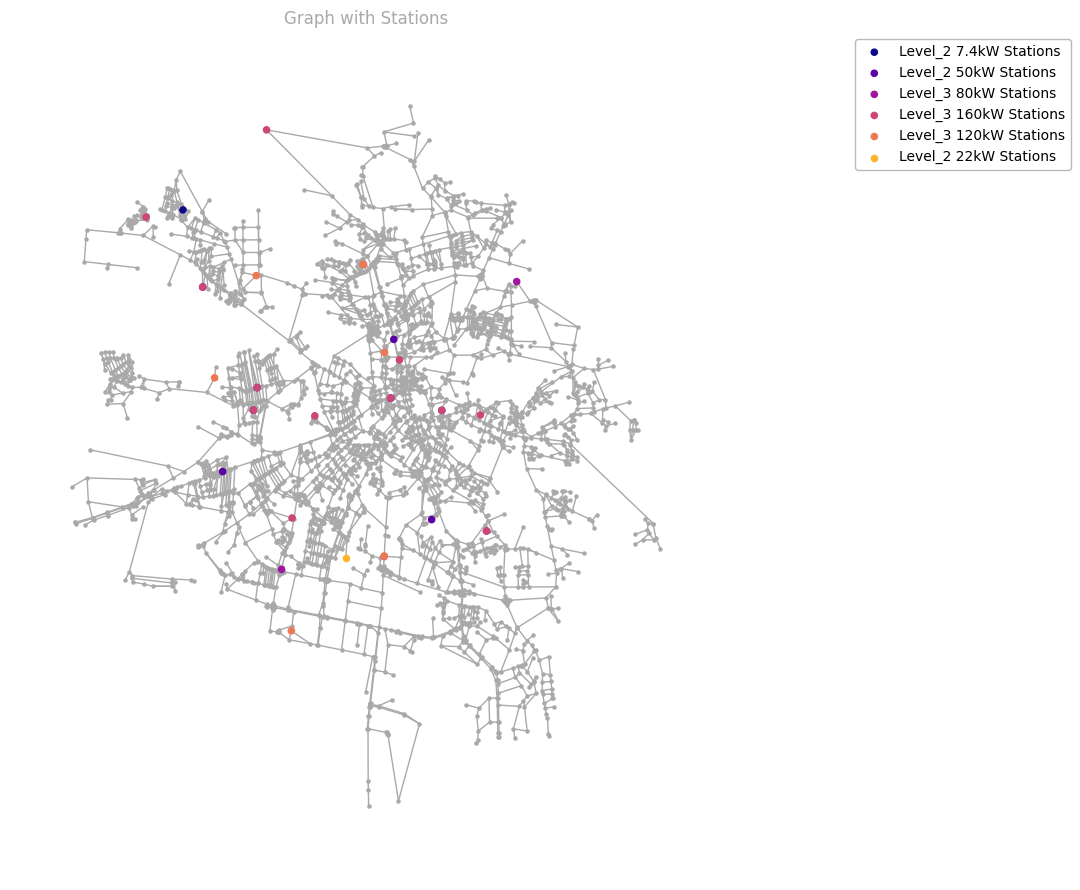

In [ ]:
plot_models_fitness(exp_result["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result["fitness_history"])
visualize_solution(exp_result["solution"], G)

## Experiment 1

- base parameters
- iterations = 3000

In [ ]:
run_sa("configs/params.yaml", "exp_sa_1.pkl", exp_config_file = "configs/experiments/exp_sa_1.yaml")

In [ ]:
with open("exp_sa_1.pkl", "rb") as f:
    exp_result1 = pickle.load(f)
exp_result1["runtime"]

5126.974046945572

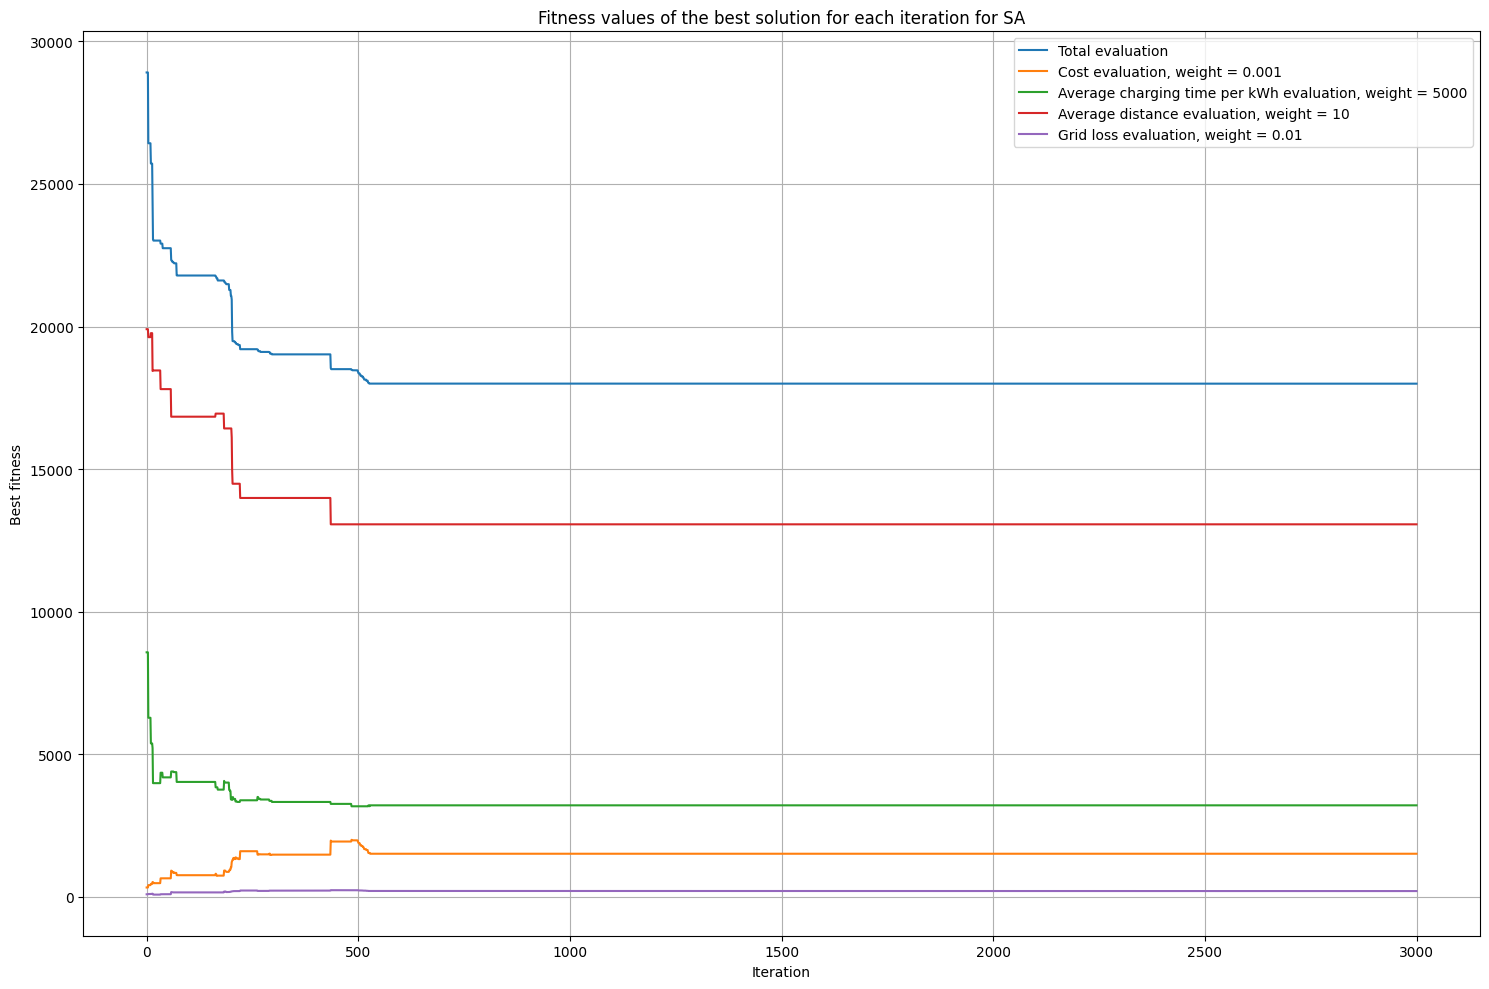

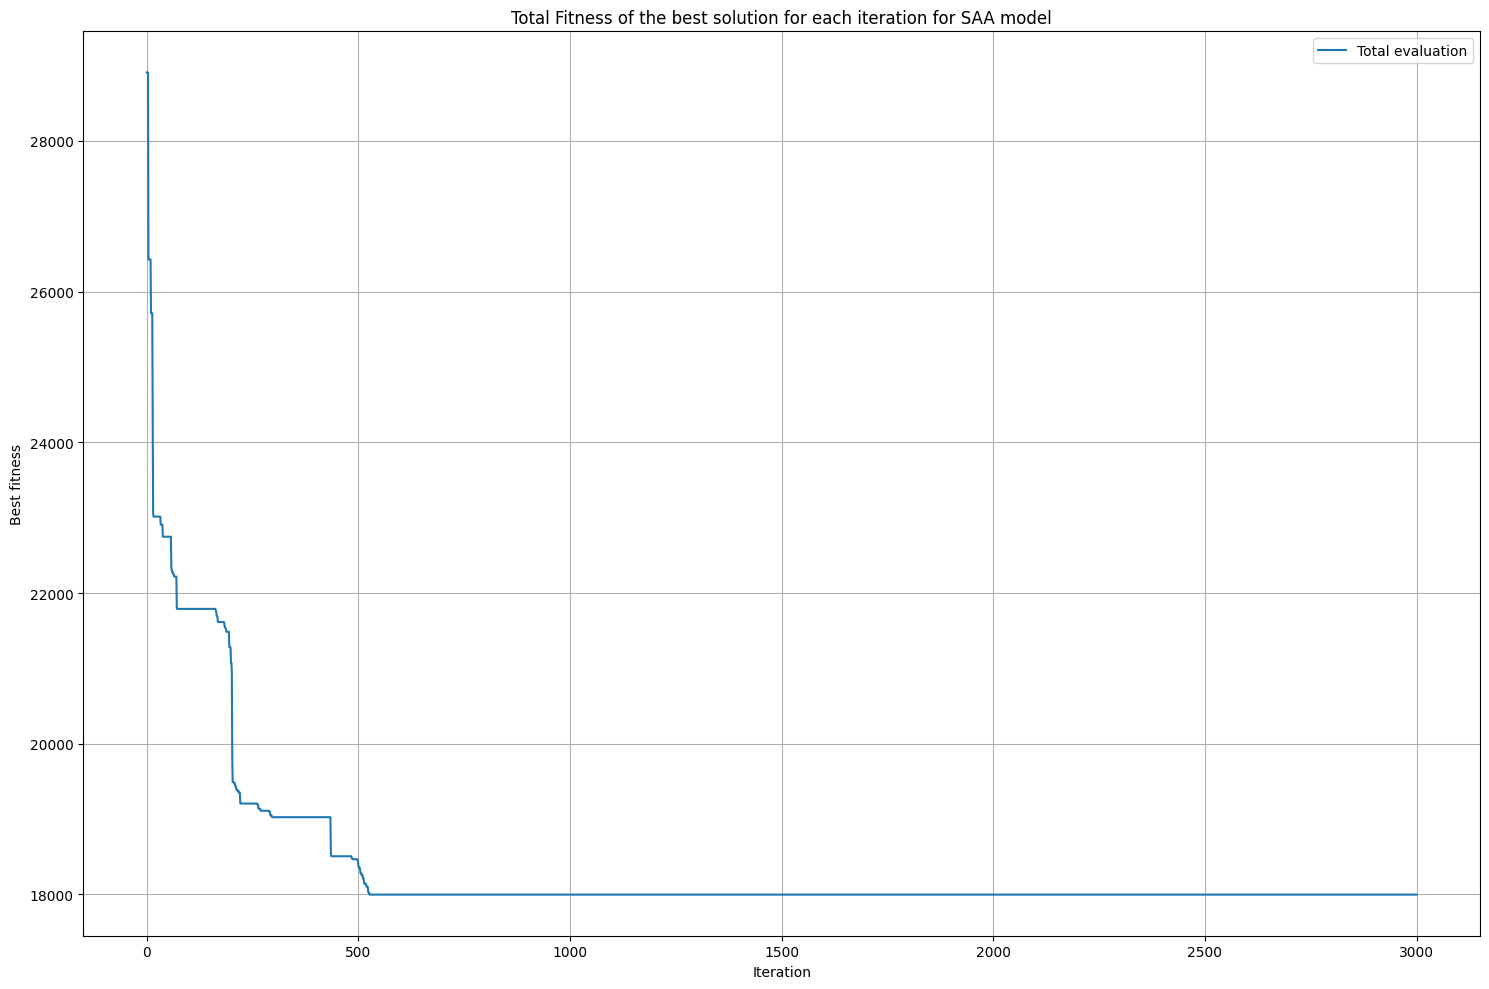

C:\Users\tetia\AppData\Local\Temp\ipykernel_27360\777376565.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


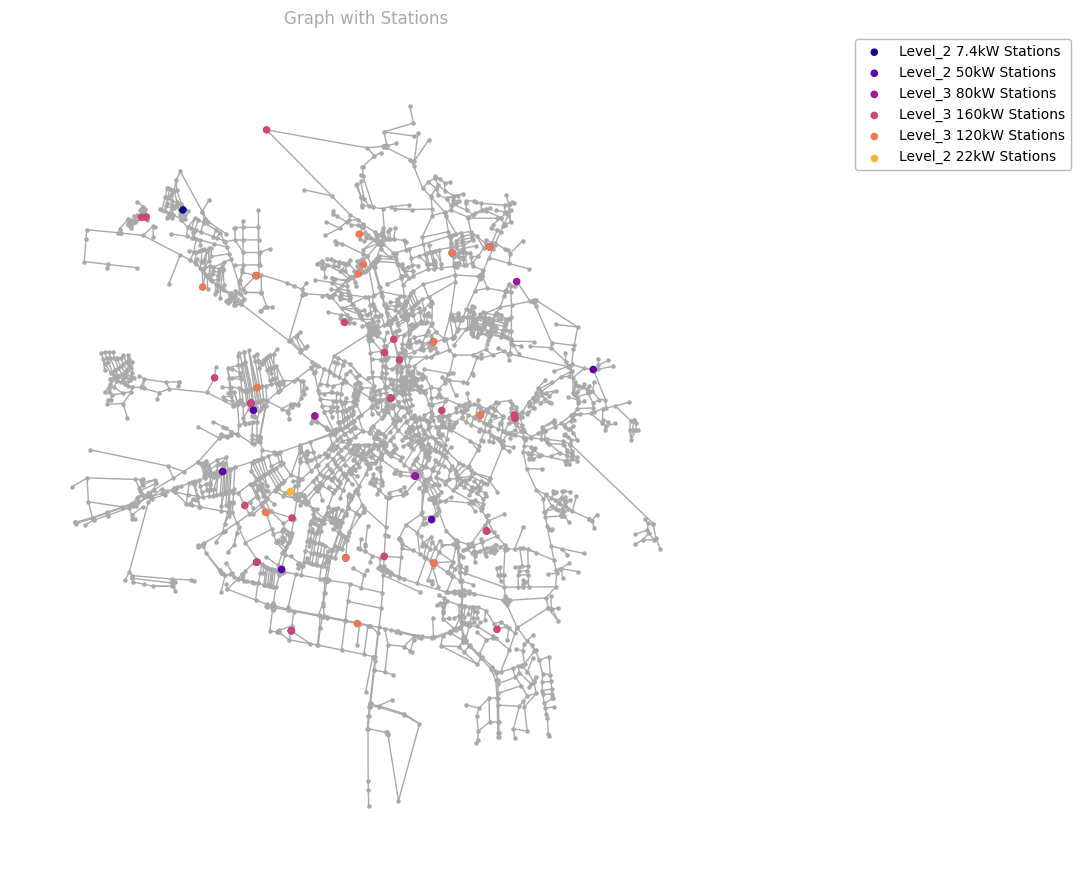

In [ ]:
plot_models_fitness(exp_result1["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result1["fitness_history"])
visualize_solution(exp_result1["solution"], G)

## Experiment 2

- base parameters
- bad_attempts_limit = 40\
(maximum number of attempts to find a better neighbor for a worse solution before returning to the best solution)

In [ ]:
run_sa("configs/params.yaml", "exp_sa_2.pkl", exp_config_file = "configs/experiments/exp_sa_2.yaml")

In [47]:
with open("exp_sa_2.pkl", "rb") as f:
    exp_result2 = pickle.load(f)
exp_result2["runtime"]

2320.4079897403717

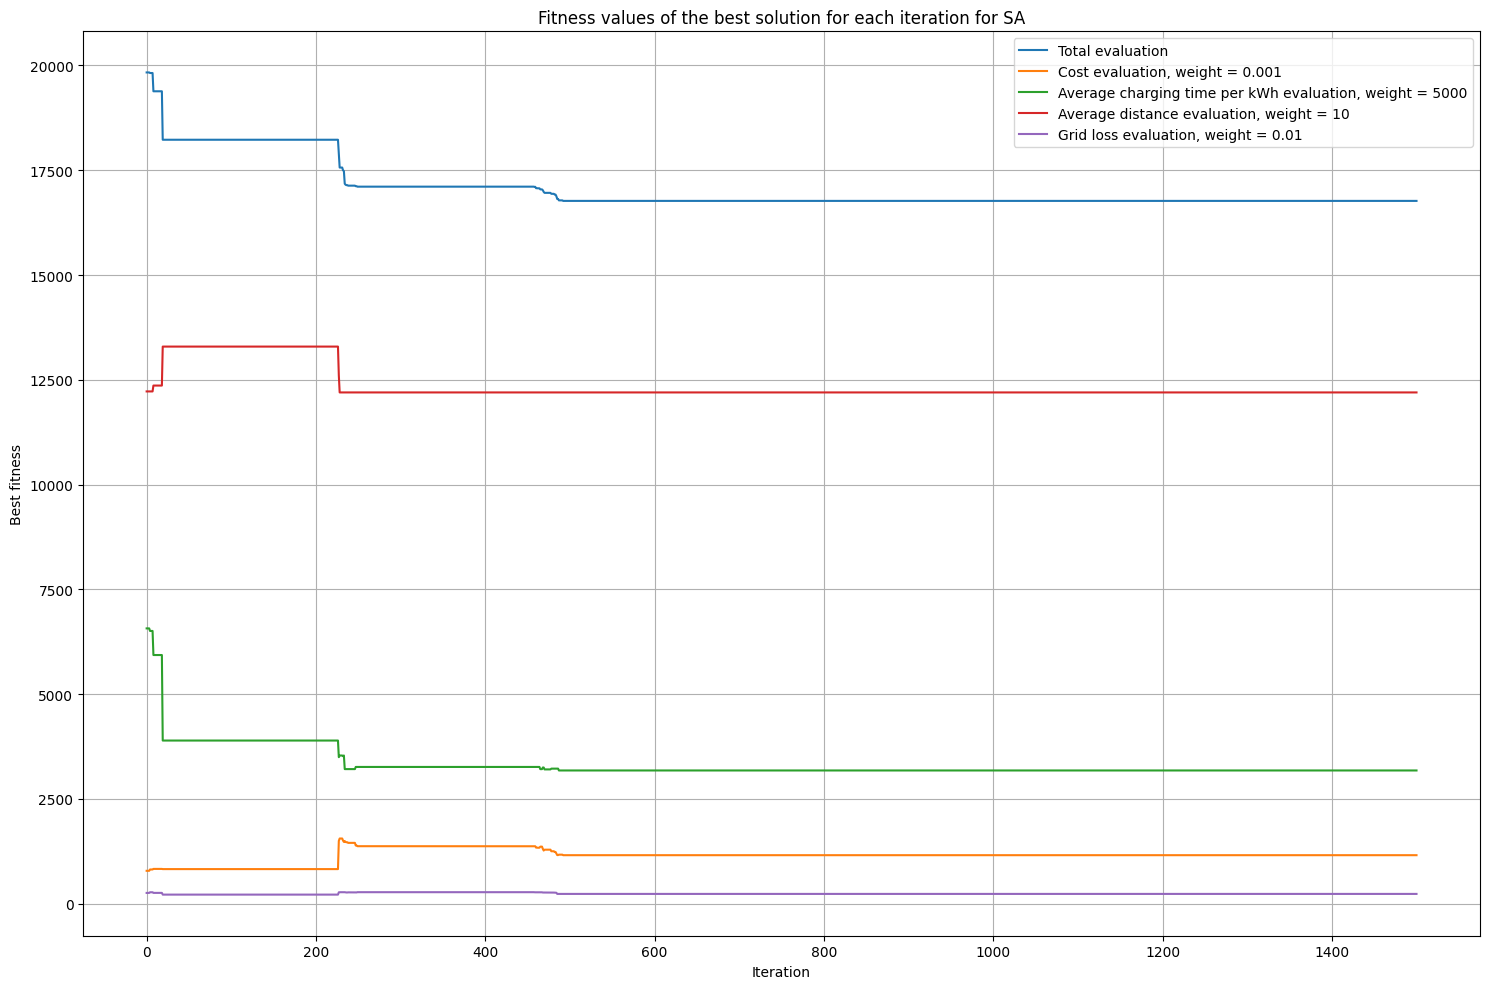

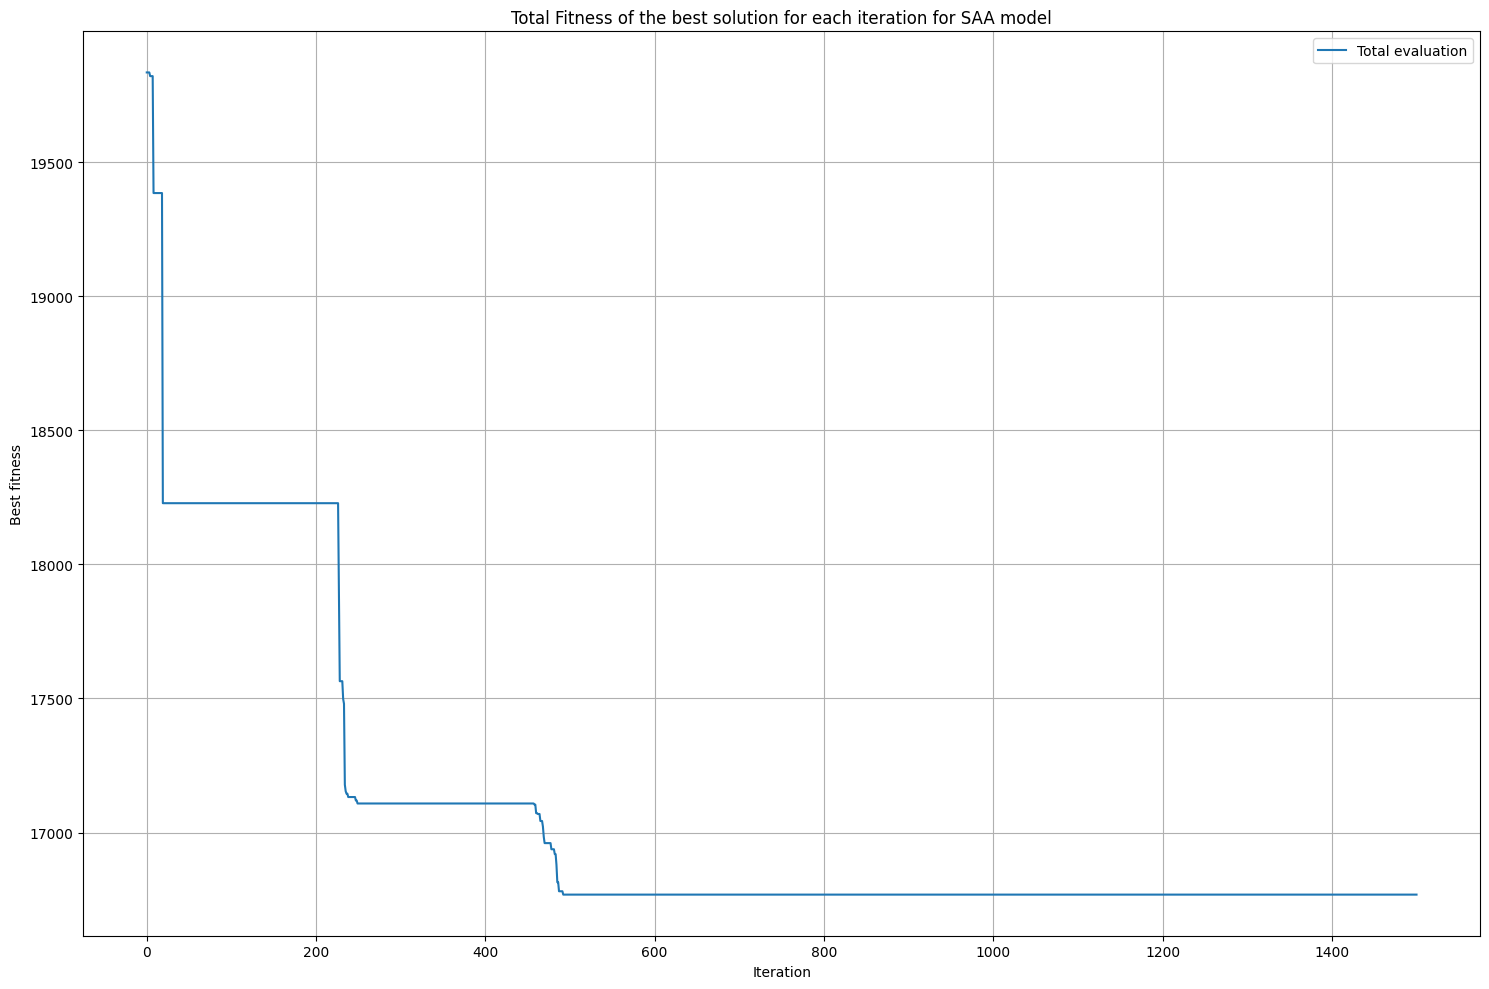

C:\Users\tetia\AppData\Local\Temp\ipykernel_9184\2990666065.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


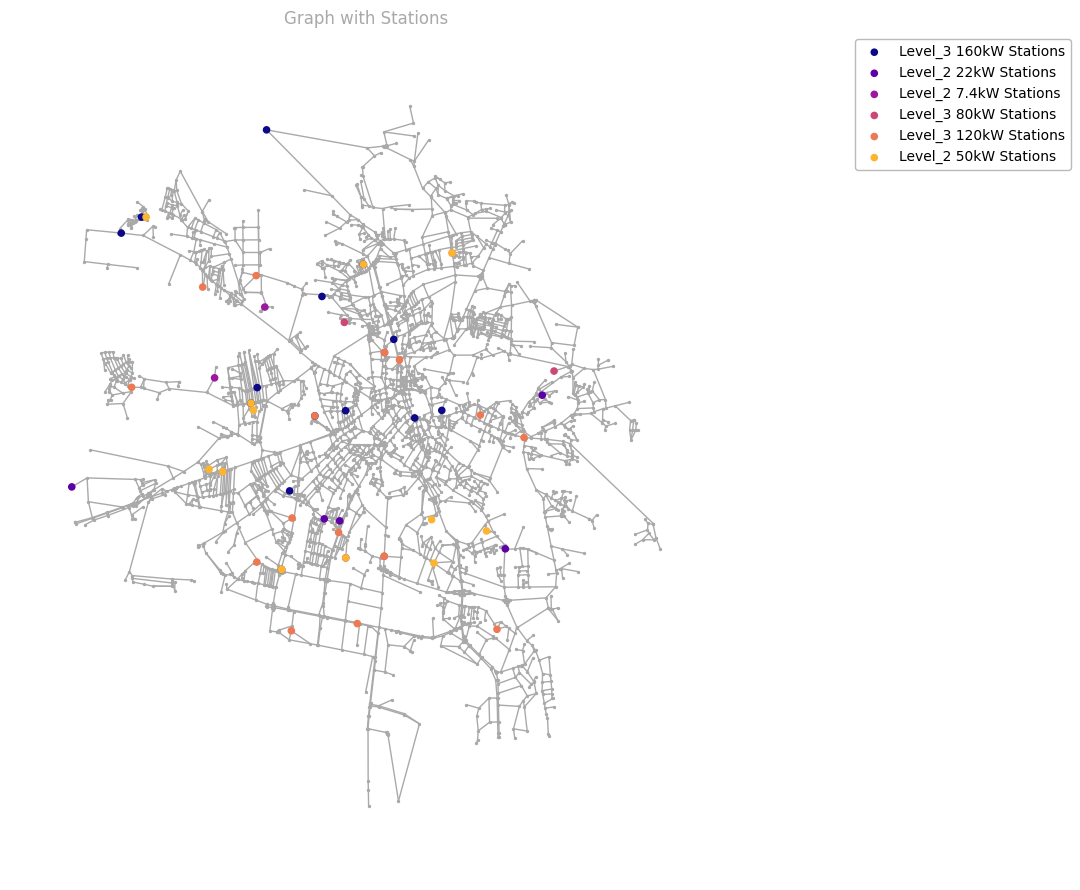

In [48]:
plot_models_fitness(exp_result2["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result2["fitness_history"])
visualize_solution(exp_result2["solution"], G)

## Experiment 3

- cooling rate = 0.999

In [ ]:
run_sa("configs/params.yaml", "exp_sa_3.pkl", exp_config_file = "configs/experiments/exp_sa_3.yaml")

In [ ]:
with open("exp_sa_3.pkl", "rb") as f:
    exp_result3 = pickle.load(f)
exp_result3["runtime"]

2600.5976734161377

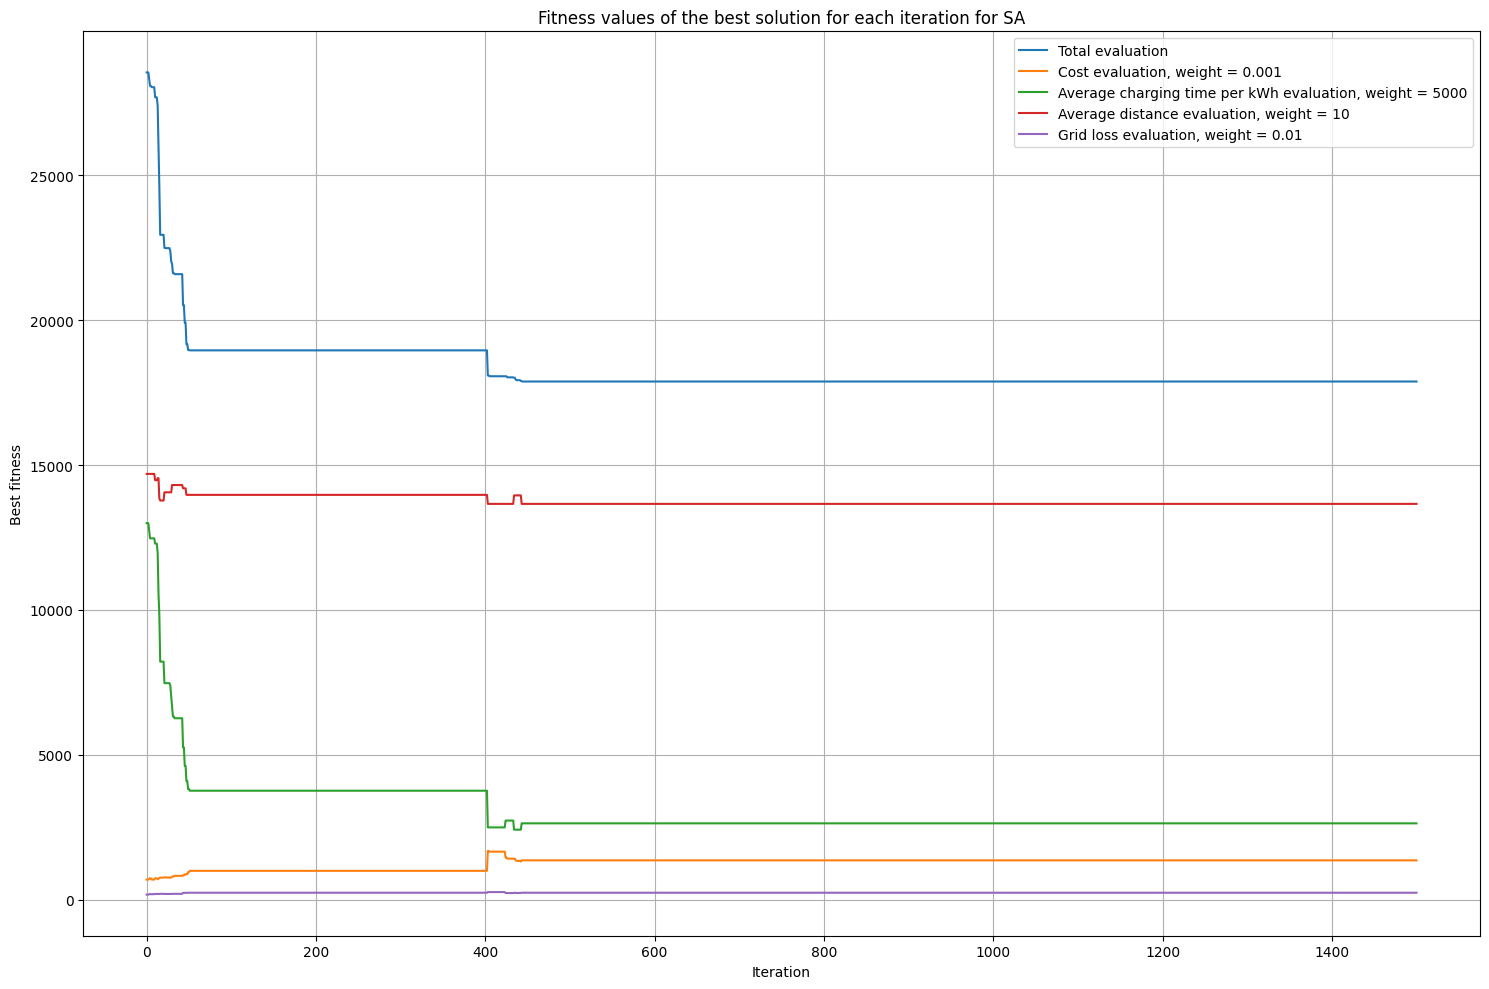

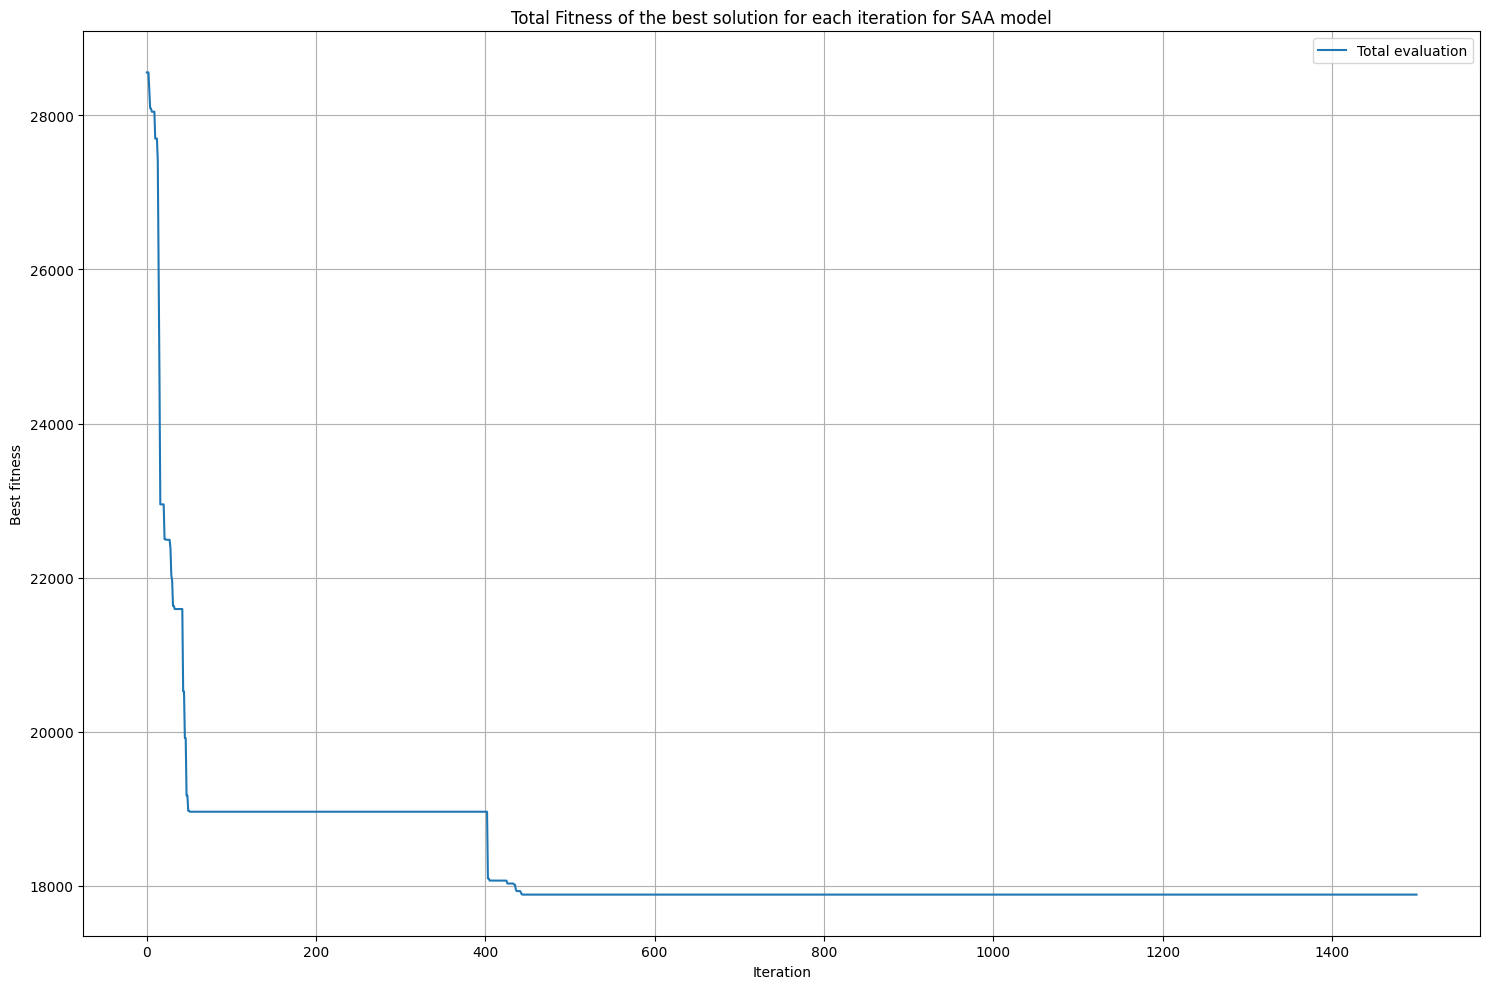

C:\Users\tetia\AppData\Local\Temp\ipykernel_27360\777376565.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


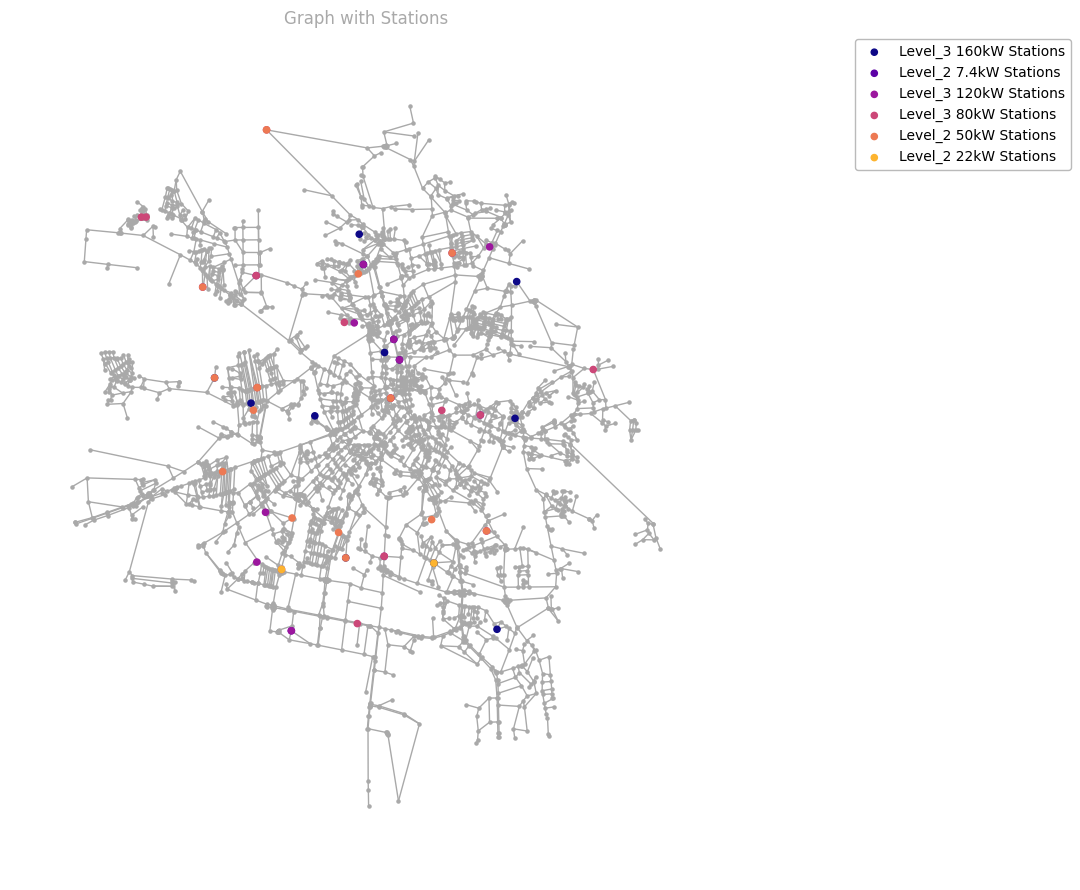

In [ ]:
plot_models_fitness(exp_result3["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result3["fitness_history"])
visualize_solution(exp_result3["solution"], G)

## Experiment 4

- base parameters
- starting temperature = 10000

In [ ]:
run_sa("configs/params.yaml", "exp_sa_4.pkl", exp_config_file = "configs/experiments/exp_sa_4.yaml")

In [54]:
with open("exp_sa_4.pkl", "rb") as f:
    exp_result4 = pickle.load(f)
exp_result4["runtime"]

1046.7988181114197

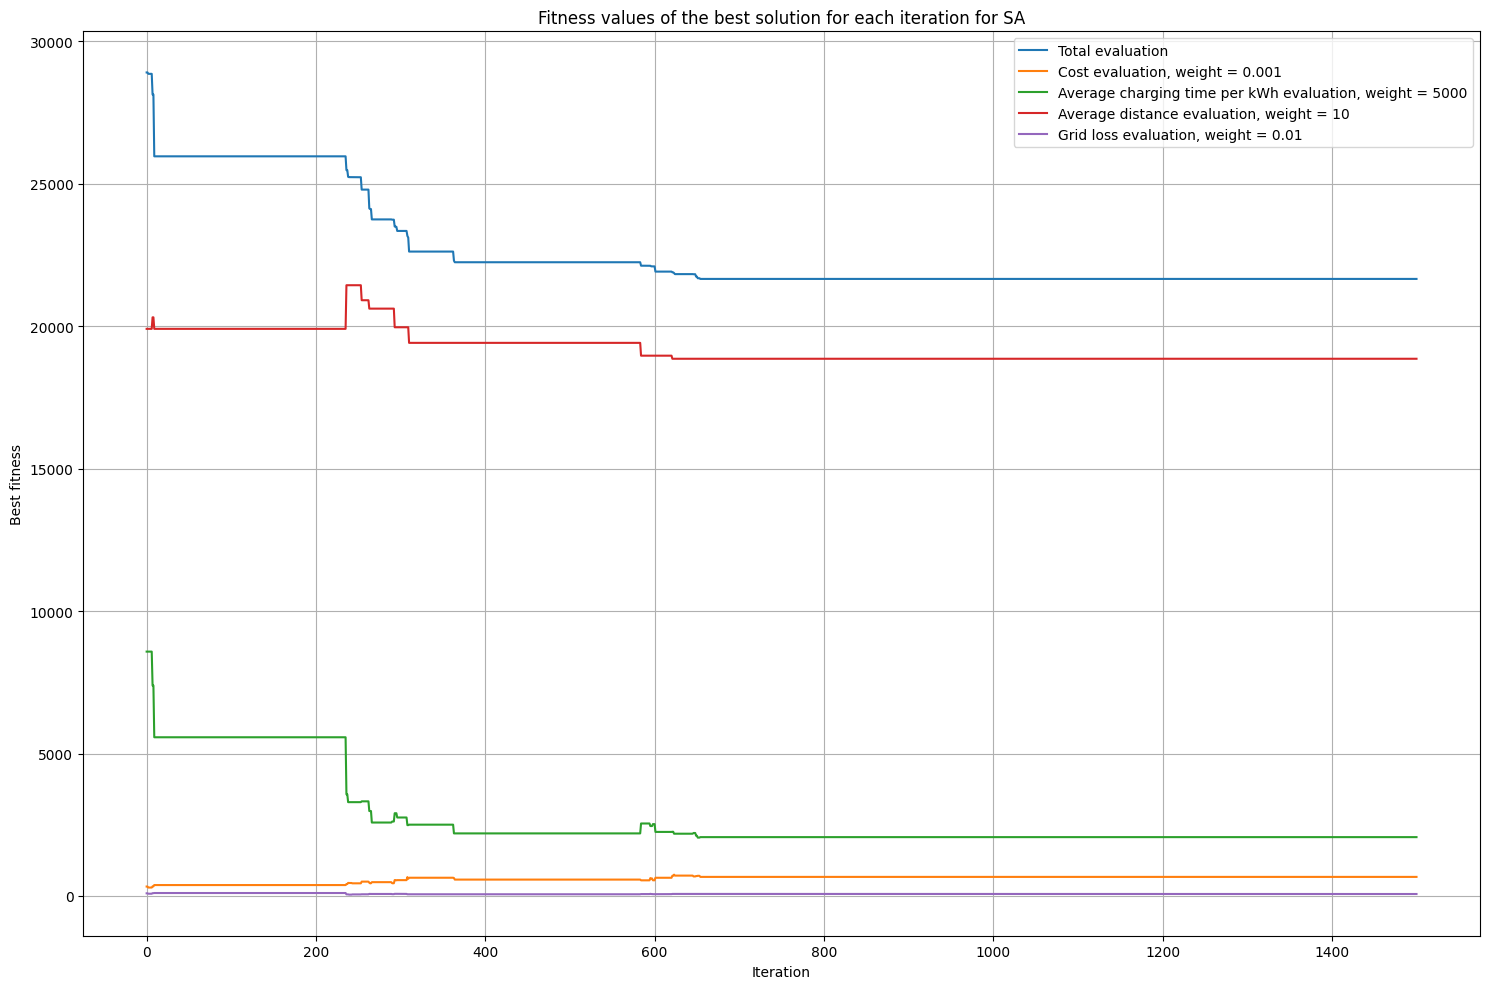

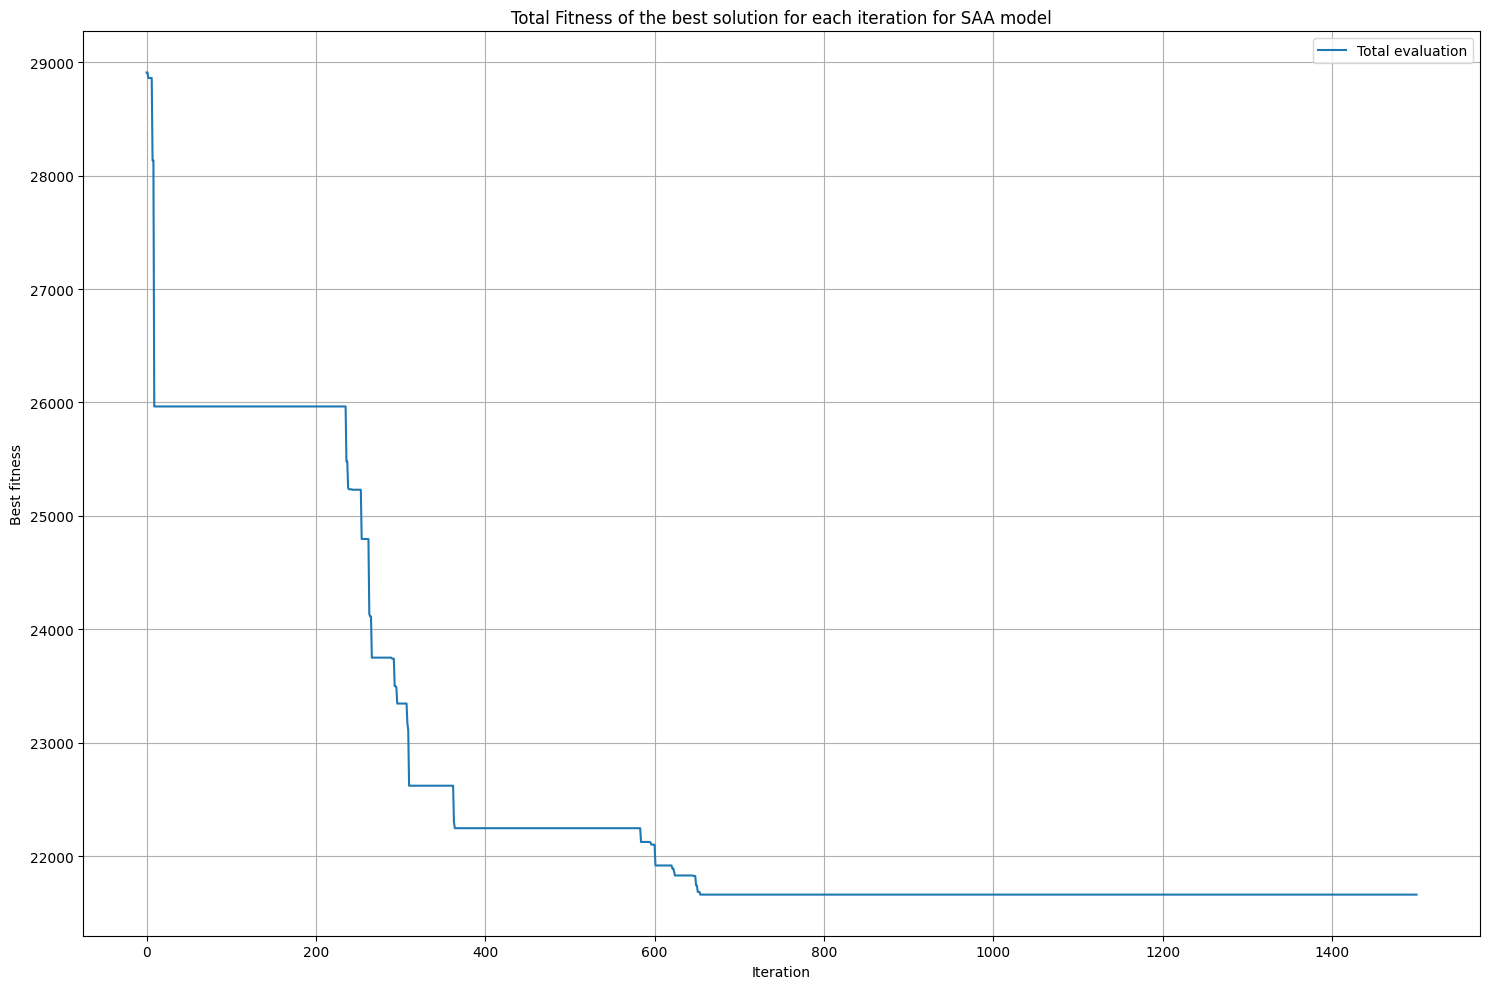

C:\Users\tetia\AppData\Local\Temp\ipykernel_9184\2990666065.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


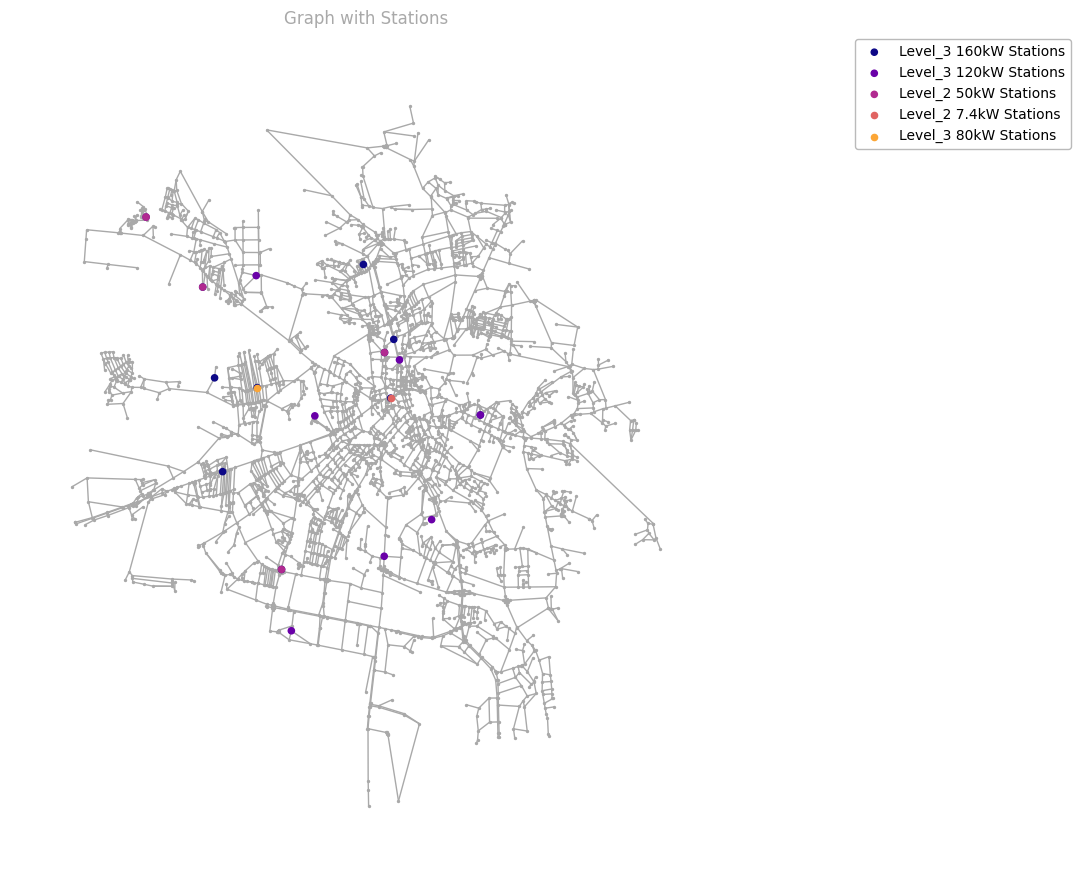

In [55]:
plot_models_fitness(exp_result4["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result4["fitness_history"])
visualize_solution(exp_result4["solution"], G)

## Experiment 5

- base parameters
- city = Kyiv

In [ ]:
run_sa("configs/params.yaml", "exp_sa_5.pkl", exp_config_file = "configs/experiments/exp_sa_5.yaml")

In [43]:
with open("exp_sa_5.pkl", "rb") as f:
    exp_result5 = pickle.load(f)
exp_result5["runtime"]

5435.174190759659

In [45]:
# plot_models_fitness(exp_result5["fitness_history"], params["evaluation_weights"])
# plot_total_fitness(exp_result5["fitness_history"])
# visualize_solution(exp_result5["solution"], G)

## Experiment 6

- base parameters
- EV per capita = 0.08

In [ ]:
run_sa("configs/params.yaml", "exp_sa_6.pkl", exp_config_file = "configs/experiments/exp_sa_6.yaml")

In [51]:
with open("exp_sa_6.pkl", "rb") as f:
    exp_result6 = pickle.load(f)
exp_result6["runtime"]

7499.273471593857

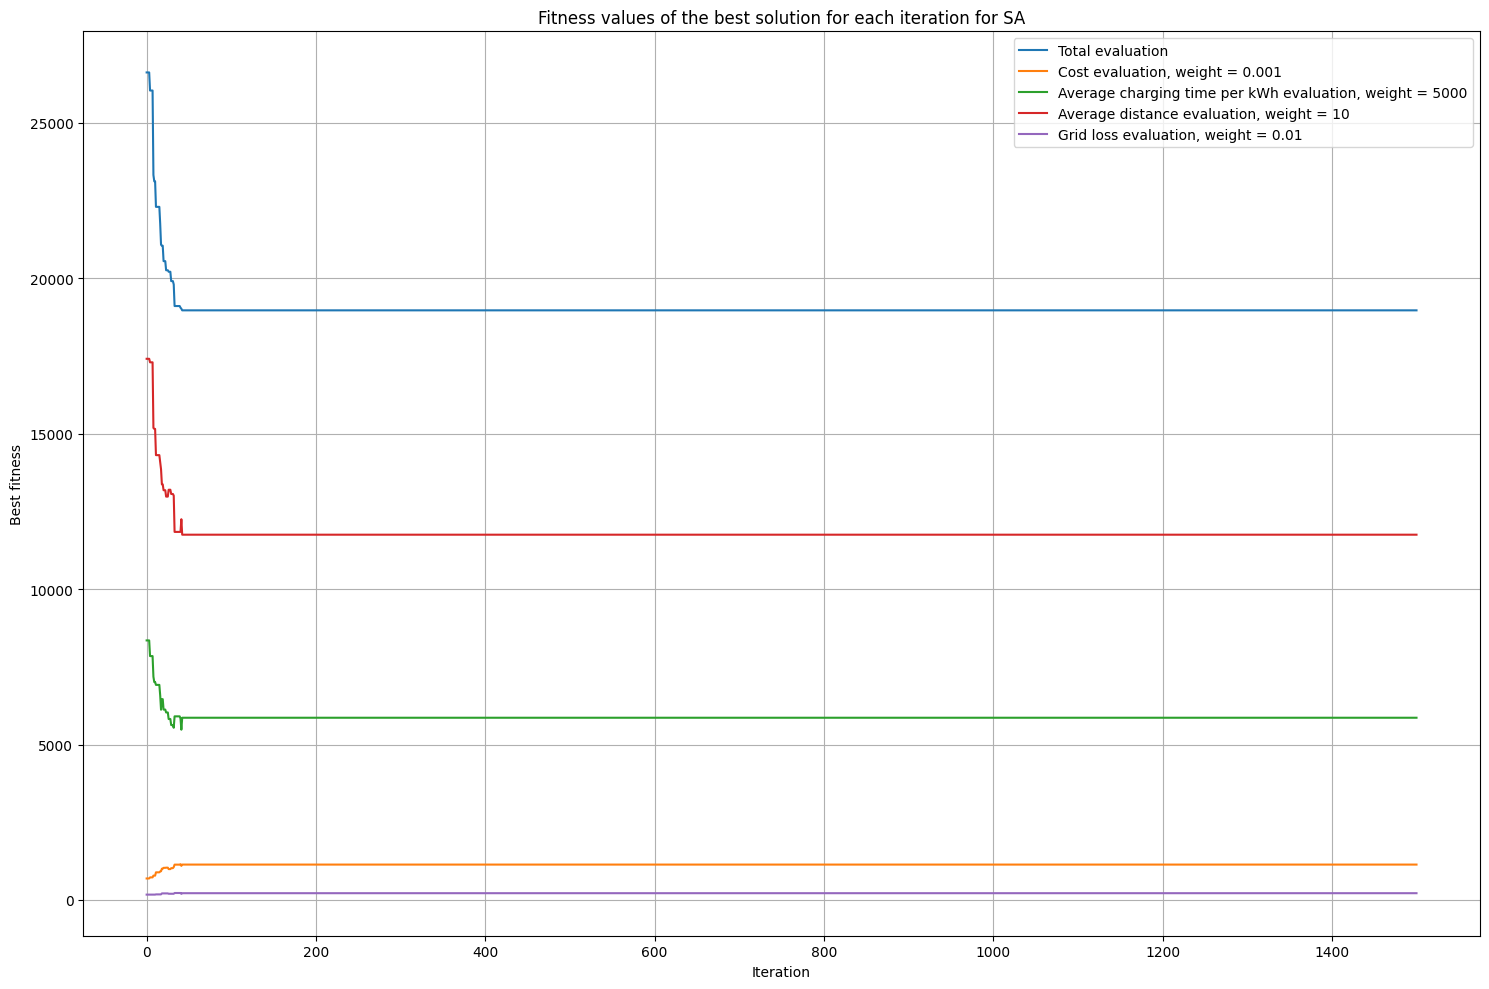

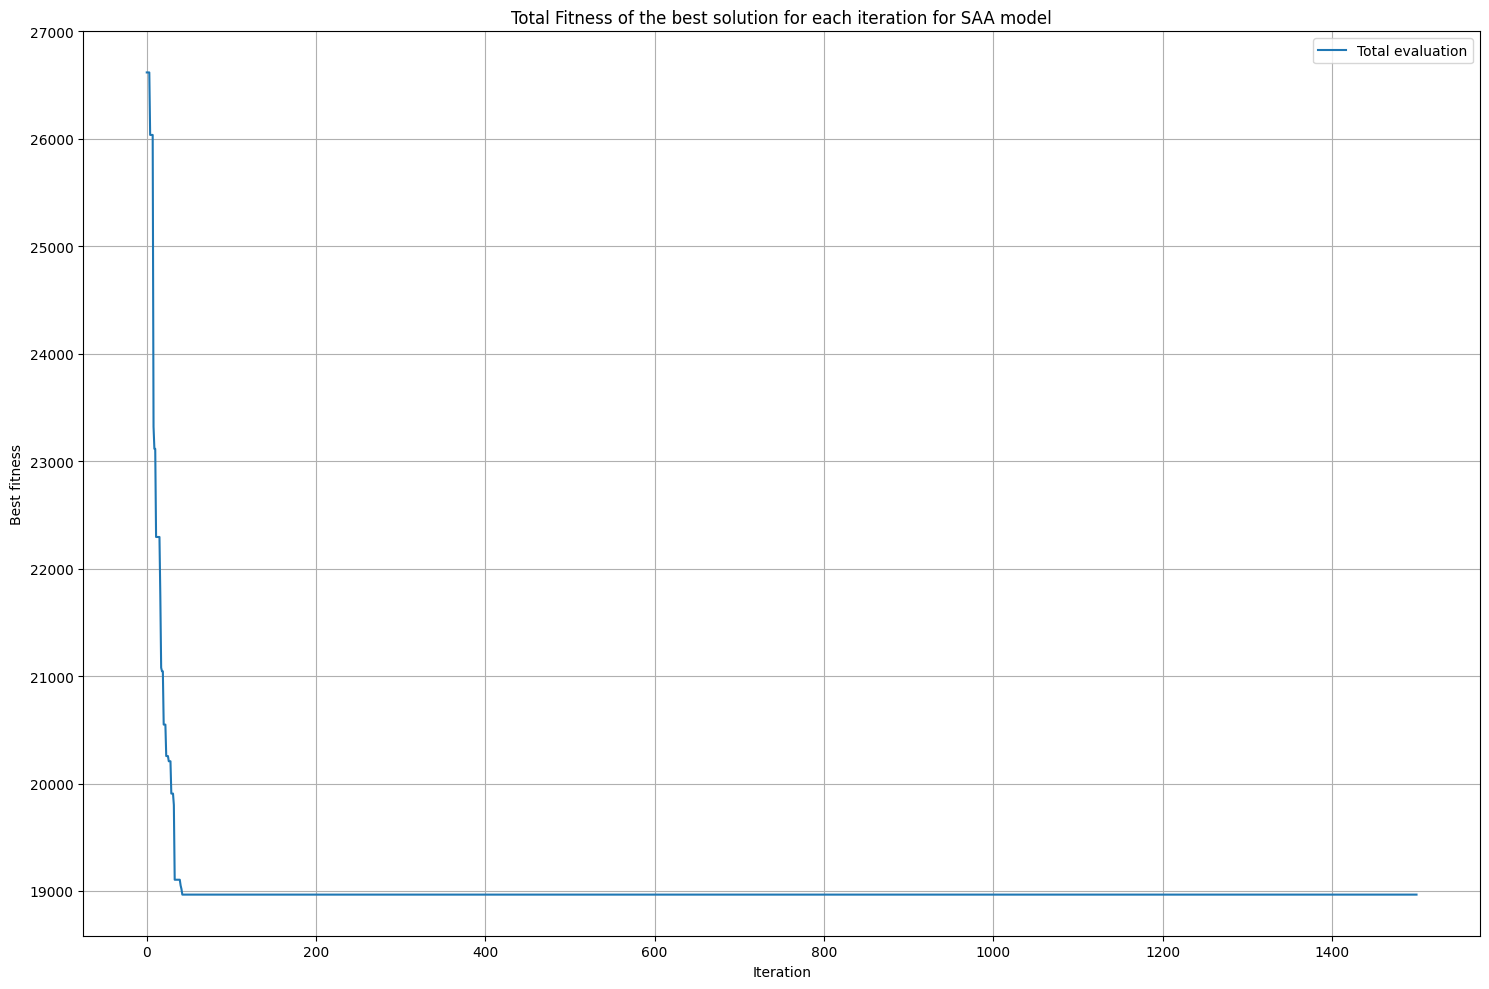

C:\Users\tetia\AppData\Local\Temp\ipykernel_9184\2990666065.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {cs_type: plt.cm.get_cmap('plasma')(i / len(unique_cs_types))


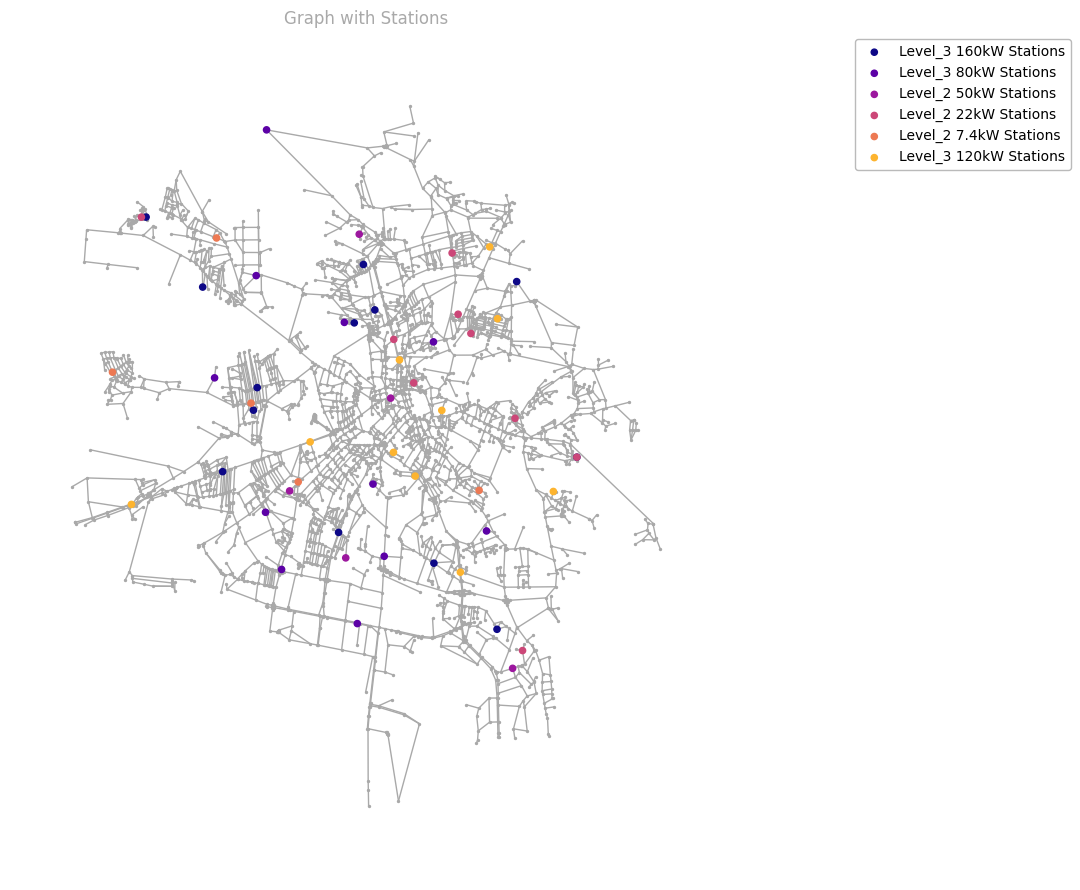

In [52]:
plot_models_fitness(exp_result6["fitness_history"], params["evaluation_weights"])
plot_total_fitness(exp_result6["fitness_history"])
visualize_solution(exp_result6["solution"], G)